# GIA - APRNS

## Sesión: Modelos Autoregresivos

Esta sesión de laboratorio vamos a probar los diferentes modelos autoregresivos que hemos visto en teoría.

Como recordaréis este tipo de modelos estiman una distribución de probabilidad asumiendo que podemos reescribirla mediante la regla del producto:

$p(x_1,...,x_n) = \prod^n_{i=1} p(x_i| x_{<i}) $

La arquitectura de la red reproduce esta estructura autoregresiva de manera que para obtener muestras/probabilidades debemos iterativamente calcular la distribución de cada variable.


Para los ejemplos de modelos autoregresivos usaremos la libreria `pytorch_generative`. Antes de ejecutar el notebook deberemos instalarla descomentando la siguiente celda. Una vez instalada deberemos **reiniciar** el notebook para que este disponible (en colab no debería hacer falta)

In [ ]:
!git clone https://www.github.com/EugenHotaj/pytorch-generative
!pip install -r pytorch-generative/requirements.txt


fatal: destination path 'pytorch-generative' already exists and is not an empty directory.


In [ ]:
!mv /content/pytorch-generative/pytorch_generative/ /content/pytorch_generative/

mv: cannot stat '/content/pytorch-generative/pytorch_generative/': No such file or directory


In [ ]:
import sys
sys.path.insert(1, "/content/pytorch_generative/")
print(sys.path)

['/content', '/content/pytorch_generative/', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython']


In [ ]:
from torch import optim
from torch.optim import lr_scheduler
from torch.nn import functional as F
import numpy as np
from pytorch_generative import datasets, models
from tqdm import  tqdm
import torch

from time import time
from datetime import timedelta
init_time = time()

device = torch.device("cuda")

torch.__version__, torch.cuda.is_available(), device

('2.5.1+cu121', True, device(type='cuda'))

In [ ]:
!nvidia-smi

Wed Nov 27 23:12:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Funciones auxiliares

Esta función realiza el entrenamiento de un modelo y retorna el valor de la función de pérdida de todo el entrenamiento.


Solo utiliza una muestra de entrenamiento, si queréis que se use una muestra de test para  monitorizar la sobre especialización o usarla para terminar el entrenamiento deberéis modificar la función vosotros.


In [ ]:
# Training loop para los diferentes modelos
def train_loop(model, optimizer, scheduler, loss_fn, dataloader, epochs):
    hist_loss = []
    pbar = tqdm(range(epochs))
    for epoch in pbar:  # bucle para todos los epochs
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            # obtenemos los datos y los subimos a la GPU
            inputs = data.to(device)

            # Reiniciamos los gradientes
            optimizer.zero_grad()

            # Aplicamos los datos al modelo
            outputs = model(inputs)

            # Calculamos la perdida
            loss = loss_fn(inputs, outputs)

            # Hacemos el paso hacia atras
            loss.backward()
            optimizer.step()

            # Vamos guardando la perdida
            running_loss += loss.item()

        if scheduler is not None:
            scheduler.step()
            lr = f'lr: {scheduler.get_last_lr()[0]:.4E}'
        else:
            lr = ''

        hist_loss.append(running_loss / i)
        pbar.set_description(f'loss: {running_loss / i:3.4f}:{lr}')

    return hist_loss

In [ ]:
# Cambiar para reducir o aumentar el tiempo de entrenamiento
epochs1 = 5000
epochs2 = 2000

# MADE (Masked Autoencoder for Density Estimation)

El primer modelo que veremos es MADE.

Este es un auto codificador que utiliza enmascaramiento (masking) para definir una red que representa una distribucion de probabilidad de manera autoregresiva. Podéis repasar los detalles del modelo en las transparencias de teoría.

Usaremos el dataset digits de `scikit-learn` seleccionando una de las clases para que no se alargue mucho el entrenamiento y binarizando su valores de manera que tengamos una distribucion binomial/Bernoulli para cada uno de los píxeles

In [ ]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

Seleccionaremos el 0, pero podéis cambiarlo al dígito que queráis

In [ ]:
Xo,y =  load_digits(n_class=10, return_X_y=True)
X = Xo[y==3]
Xb = Binarizer(threshold=7).fit_transform(X)

Podemos ver los ejemplos antes y despues de la binarización. Cambiando el valor límite al binarizar cambiaremos la distribución. En este caso hemos puesto el límite en el valor de pixel 7.

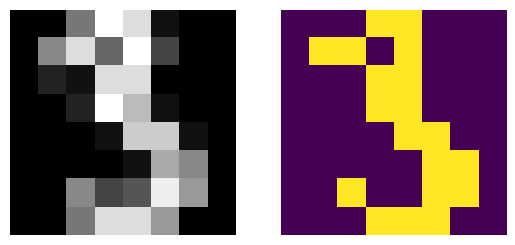

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(X[0].reshape(8,8),cmap='gray')
ax1.axis('off')
ax2.matshow(Xb[0].reshape(8,8))
ax2.axis('off')
0;

Necesitaremos un dataloader para hacer el bucle de entrenamiento del modelo. En este caso convertiremos los datos a tensores y los redimensionaremos para que sean una matriz cuadrada (8x8) en lugar de un vector como están originalmente.

In [ ]:
# Dataset para los digitos binarizados
class BinDigits(Dataset):
    def __init__(self, data):
        self.data = torch.reshape(torch.Tensor(data), (-1,8,8)).unsqueeze(1)

    def __getitem__(self, index):
        x = self.data[index]

        return x

    def __len__(self):
        return len(self.data)

digdata = BinDigits(Xb)
bindig_dl = torch.utils.data.DataLoader(digdata, batch_size=32)

Definimos como función de perdida la entropia cruzada binaria. En este caso estamos aprendiendo una distribución binomial para las variables y queremos que se acerquen a los valores binarios de los píxeles.

In [ ]:
def loss_fn(x, preds):
    batch_size = x.shape[0]
    x, preds = x.view((batch_size, -1)), preds.view((batch_size, -1))
    loss = F.binary_cross_entropy_with_logits(preds, x, reduction="none")
    return loss.sum(dim=1).mean()

Definimos un modelo MADE con entrada el tamaño de la imagen y una capa oculta con cierto número de neuronas.

Aumentar el numero de capas/neuronas aumentará la capacidad del modelo. Habría que hacer un ajuste de este hiperparámetros para encontrar el mejor valor. En este caso probaremos una sola capa con 200 neuronas.

El modelo conectará la entrada con la capa oculta de maner autoregresiva utilizando las restricciones de conexión que comentamos en teoría, de manera que cada entrada solo dependa de las entradas anteriores.

Para hacer la optimización usaremos Adam y ajustaremos la tasa de aprendizaje usando un scheduler que la va reduciendo mediante un factor multiplicativo.

In [ ]:
made_model = models.MADE(input_dim=64, hidden_dims=[200], n_masks=1)
made_model.to(device)
optimizer = optim.Adam(made_model.parameters(), lr=1e-3)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.99999)

In [ ]:
made_loss = train_loop(made_model, optimizer, scheduler, loss_fn, bindig_dl, epochs1)

loss: 7.2106:lr: 9.5123E-04: 100%|██████████| 5000/5000 [01:38<00:00, 50.90it/s]


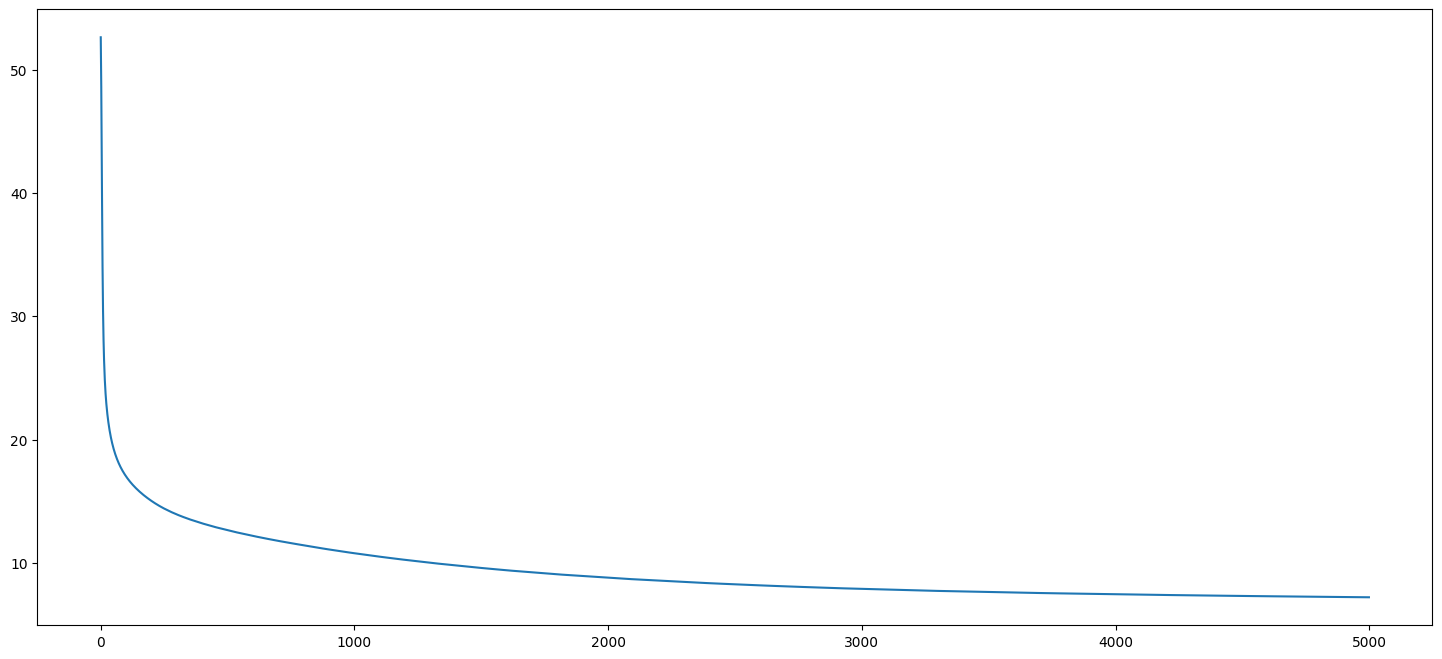

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(made_loss);

Podemos ver que la función de pérdida se reduce paulatinamente hasta casi converger.

Obviamente no podemos fiarnos de esto ya que siempre necesitamos una muestra de validación para asegurarnos que no nos estemos sobre especializando. Dejaremos esto como un ejercicio para el lector.

Una vez hemos entrenado el modelo podemos obtener muestras para comprobar si al menos visualmente corresponden con lo que debería.

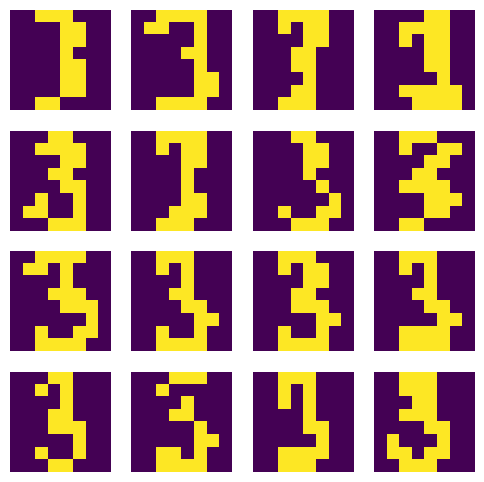

In [ ]:
nim = 4

made_samp=made_model.sample(n_samples=nim*nim)

fig = plt.figure(figsize=(6,6))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(made_samp[i].cpu().permute(1,2,0))
    plt.axis('off')

Podemos ver que los dígitos que generamos tienen la forma adecuada.

Las muestras se han obtenido a partir del modelo autoregresivo píxel a píxel calculando su probabilidad y escogiendo un 0 o un 1 dependiendo de esta. Obviamente, repitiendo el muestreo podemos generar todos los digitos que queramos.

---
<font color="blue" size=4>
 Dado que el primer píxel es una variable independiente ¿cual os parece que es la distribución que ha aprendido en este caso?
 </font>
<br><br>
<font color="blue" size=4>
Pensadlo un momento y comentadlo entre vosotros.
 </font>

---



La gracia de tener un modelo que calcula probabilidades es obtener la probabilidad que corresponde a las muestras. El modelo es capaz de calcular los logits correspondientes a cada pixel. Aplicando la función sigmoide podemos obtener la probabilidad de que pixel tenga un valor de 1 (Bernoulli)

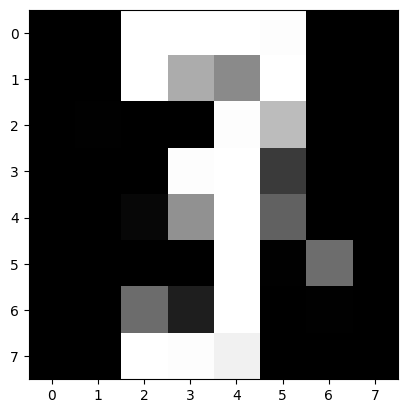

In [ ]:
lg = torch.sigmoid(made_model(made_samp[2]).detach())

plt.imshow(lg.cpu().permute(1,2,0), cmap='gray');

Podemos hacerlo también para uno de los ejemplos de entrenamiento

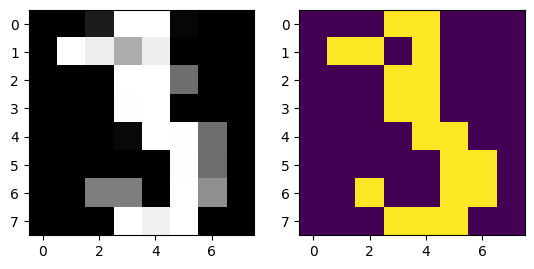

In [ ]:
lg = torch.sigmoid(made_model(torch.tensor(Xb[0].reshape((-1,8,8)), dtype=torch.float32).to(device)).detach())
plt.subplot(1, 2, 1)
plt.imshow(lg.cpu().permute(1,2,0), cmap='gray');
plt.subplot(1, 2, 2)
plt.imshow(Xb[0].reshape(8,8));


---
<font color="blue" size=4>
La siguiente función calcula la log verosimilitud negativa de un conjunto de muestras
</font>
<br><br>

<font color="blue" size=4>
Intenta explicar lo que esta haciendo sabiendo que estamos modelando las variables como distribuciones de Bernoulli
</font>

---

In [ ]:
def nll(model, samp):
    epsilon = 1e-15
    snll = 0.0
    for i in range(samp.shape[0]):
        mu = torch.sigmoid(model(samp[i]).detach())
        snll += ((samp[i] * torch.log(mu+epsilon)) + ((1-samp[i]) * torch.log(1-mu+epsilon))).sum()
    return -snll.cpu()

Esta es la log verosimilitud negativa de las primeras 100 muestras

In [ ]:

nll(made_model, torch.tensor(Xb[:100].reshape((-1,8,8)), dtype=torch.float32).unsqueeze(1).to(device))

tensor(606.4549)

Otra ventaja de tener un modelo autoregresivo es que podemos hacer el completado de muestras parciales. Por ejemplo, podemos coger una muestra del conjunto de entrenamiento, ocultarla parcialmente y obtener el resto de la muestra condicionando el modelo a la entrada parcial.

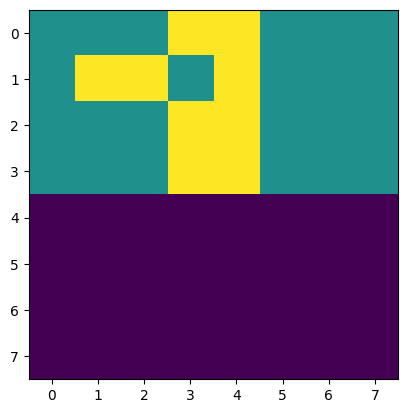

In [ ]:
cond = Xb[0].copy()
cond[32:]=-1
plt.imshow(cond.reshape((8,8)));

Obviamente si hacemos el muestreo varias veces obtendremos resultados distintos. Podemos comparar tambien con el ejemplo real.

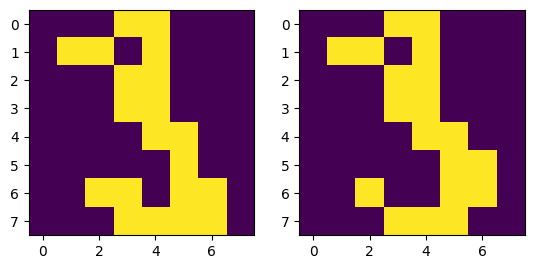

In [ ]:

csamp=made_model.sample(n_samples=1,conditioned_on=torch.reshape(torch.Tensor(cond), (-1,8,8)).unsqueeze(1).to(device))
plt.subplot(1, 2, 1)
plt.imshow(csamp[0].cpu().permute(1,2,0));
plt.subplot(1, 2, 2)
plt.imshow(Xb[0].reshape(8,8));

# Pixel CNN


Pixel CNN utiliza convoluciones para definir un modelo autoregresivo que se adapta mejor a imágenes asumiendo que la influencia sobre la probabilidad de un píxel proviene de los que tiene alrededor, de manera que tenemos conexiones locales entre las variables del modelo.

Como recordaréis, estamos usando una convolucion 2D causal, por lo que estamos usando solo los píxeles que están por encima y en la misma fila a la izquierda del pixel sobre la que la estamos aplicando

![pixelcnn](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-16_at_7.27.51_PM_tpsd8Td.png)


La red esta compuesta por una secuencia de bloques residuales (n_residual) donde cada bloque residual tiene cierto numero de canales (residual_channels), la entrada de la red esta compuesta por convoluciones 1x1 que adaptan el tamaño de la salida (head_channels)

Haremos un ajuste de este modelo con los mismos datos. Debemos ajustar los hiper párametros de la red para obtener un modelo razonable. En este caso usaremos el mismo procedimiento de entrenamiento (los hiperparámetros de la red deberían ajustarse, pero se han escogido _mágicamente_)

In [ ]:
pcnn_model = models.PixelCNN(in_channels=1, out_channels=1, n_residual=2, residual_channels=6, head_channels=12)
pcnn_model.to(device)
optimizer = optim.Adam(pcnn_model.parameters(), lr=1e-3)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.99999)

In [ ]:
pcnn_loss = train_loop(pcnn_model, optimizer, scheduler, loss_fn, bindig_dl, epochs1)

loss: 14.1221:lr: 9.5123E-04: 100%|██████████| 5000/5000 [02:24<00:00, 34.65it/s]


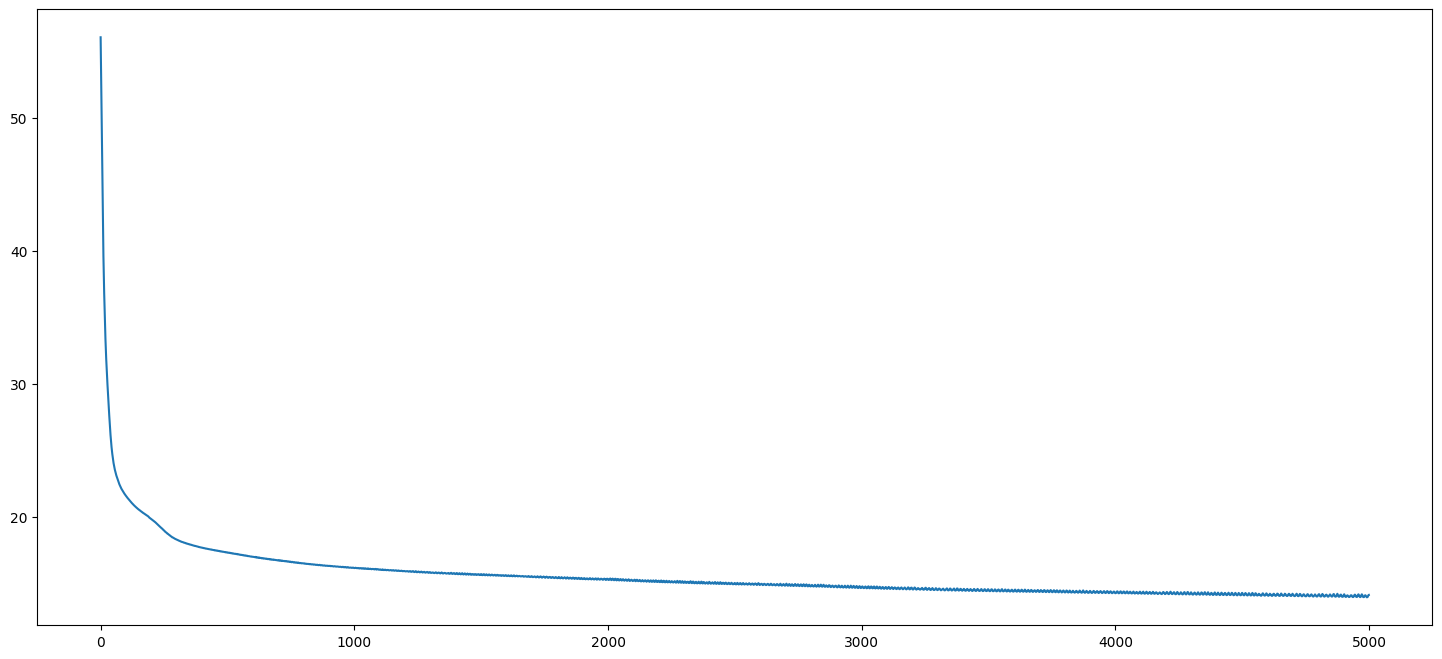

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(pcnn_loss);

Podemos ver las muestras que genera este modelo

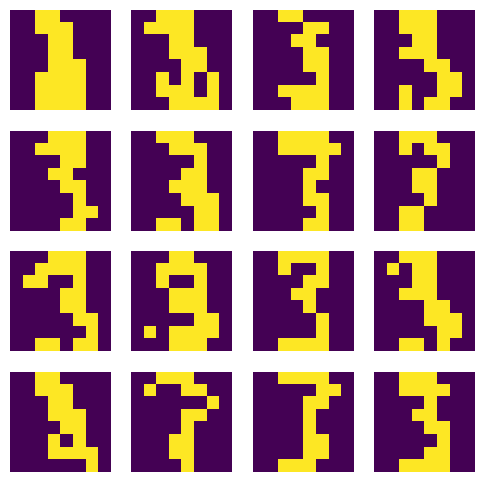

In [ ]:
nim = 4
pcnn_samp=pcnn_model.sample(n_samples=nim*nim)
fig = plt.figure(figsize=(6,6))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(pcnn_samp[i].cpu().permute(1,2,0))
    plt.axis('off')

Podemos ahora comparar las probabilidades que asigna este modelo a los datos de entrenamiento con las que generaba MADE.

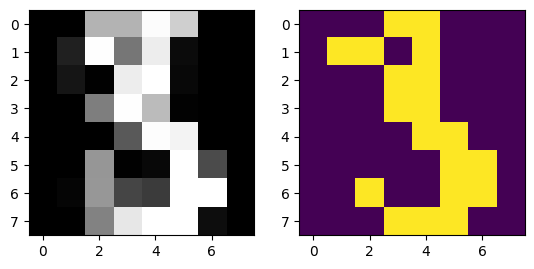

In [ ]:
lg = torch.sigmoid(pcnn_model(torch.tensor(Xb[0].reshape((-1,8,8)), dtype=torch.float32).to(device)).detach())
plt.subplot(1, 2, 1)
plt.imshow(lg.cpu().permute(1,2,0), cmap='gray');
plt.subplot(1, 2, 2)
plt.imshow(Xb[0].reshape(8,8));

y la NLL de las 100 primeras muestras (deberiamos poder ajustar los hiperparametros del modelo y su capacidad para tener una NLL mas pequeña, lo dejamos como ejercicio para el lector)

In [ ]:
nll(pcnn_model, torch.tensor(Xb[:100].reshape((-1,8,8)), dtype=torch.float32).unsqueeze(1).to(device))

tensor(1176.1365)

# Pixel CNN (Double down)

Modelar los datos binarios no es lo mas adecuado, pero la implementación por defecto de los modelos que tiene la librería solo permite este tipo de datos. Una alternativa sería modelar los diferentes valores de los píxeles usando canales en la imagen. Hasta ahora solo tenemos un canal, podemos generar 17 canales que correspondan con los valores correspondientes a cada pixel. Esto es parecido a lo que se hace para representar los colores en las imagenes RGB, tenemos tres colores separados que se combinan para obtener el color real.

Podemos hacer esto simplemente haciendo un one hot encoding de los valores que tiene la imagen. Este es un data loader que hace eso.

In [ ]:
# Dataset para los digitos usando OneHot Encoding de sus valores (0-16)
class Digits(Dataset):
    def __init__(self, data):
        self.data = torch.reshape(torch.Tensor(data), (-1,8,8))

    def __getitem__(self, index):
        x = self.data[index]

        return F.one_hot(x.long(), num_classes=17).to(torch.float32).permute(2,0,1)

    def __len__(self):
        return len(self.data)

digdata = Digits(X)
digits_dl = torch.utils.data.DataLoader(digdata, batch_size=64)

---


<font color="blue" size=4>
Esta parece una manera sencilla de transformar un problema que no es binario a uno binario, pero realmente estaremos aprendiendo una distribución de probabilidad que será más compleja de lo necesario.
 </font>

 - ¿Qué diferencia hay entre la distribucion autoregresiva que modela la red y las dependencias que hay realmente entre los valores de los píxeles?

 - ¿Recordáis cómo se modela la salida multinomial en PixelCNN? ¿Qué ventaja/diferencia tiene respecto a hacerlo así?

 - ¿Recordáis cómo se modela en PixelCNN++?

---

Podemos ver que ahora un ejemplo es un tensor 17 * 8 * 8

In [ ]:
digdata[0].shape

torch.Size([17, 8, 8])

Ahora necesitaremos una red con algo más de capacidad, además deberíamos hacer una exploración para ajustar sus hiperparámetros (ahora estan ajustados mágicamente &#x1F609;).

Estamos también multiplicando el tamaño de los datos por 17 y aunque la capacidad de proceso de la GPU sera suficiente en este caso (tenemos pocos datos) podéis ver que no es una estrategia escalable.

In [ ]:
pcnn2_model = models.PixelCNN(in_channels=17, out_channels=17, n_residual=8, residual_channels=24, head_channels=16)
pcnn2_model.to(device)
optimizer = optim.Adam(pcnn2_model.parameters(), lr=1e-4)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.9999)

In [ ]:
pcnn2_loss = train_loop(pcnn2_model, optimizer, scheduler, loss_fn, digits_dl, epochs1)

loss: 19.3526:lr: 6.0652E-05: 100%|██████████| 5000/5000 [03:29<00:00, 23.87it/s]


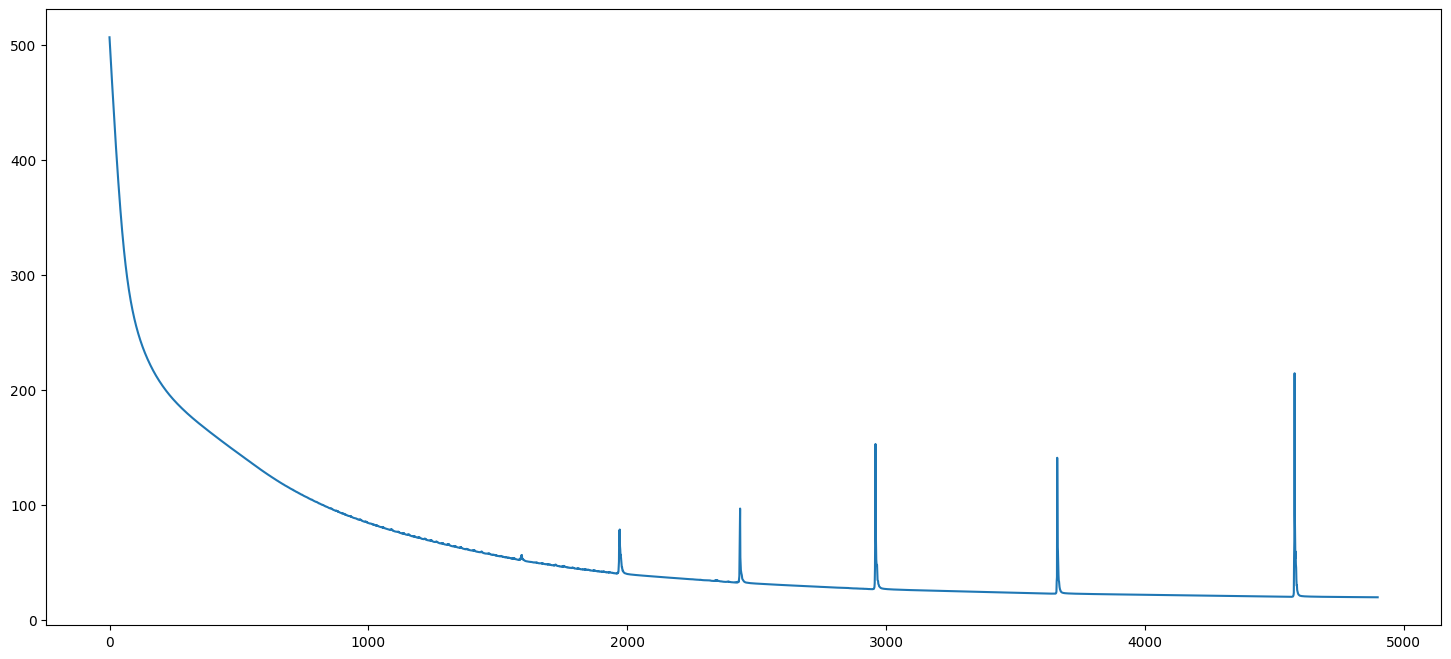

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(pcnn2_loss[100:]);

Si generamos muestras con el modelo aprendido, no son maravillosas, pero algunas tienen cierto parecido en forma a lo que queremos aprender. Probablemente la intensidad del pixels no sea demasiado buena.

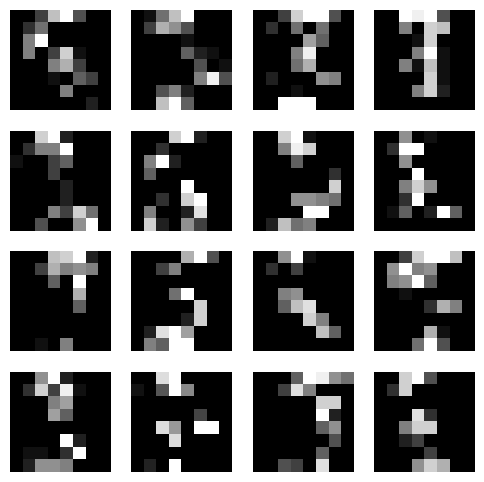

In [ ]:
nim = 4
pcnn_samp=pcnn2_model.sample(n_samples=nim*nim)
fig = plt.figure(figsize=(6,6))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(np.argmax(pcnn_samp[i].cpu().numpy(), axis=0),cmap='gray')
    plt.axis('off')

---
  <font color="blue" size=4>
Fijaos en qué se esta haciendo para representar los valores de los píxeles de los dígitos</font>

 -  ¿Qué valor tenemos para la intensidad de cada píxel?
 - ¿Qué problema nos encontraremos con los valores que corresponden a un píxel? ¿cómo deberíamos  obtener el valor de mayor intensidad del píxel ?

---


# Gated Pixel CNN

El problema de pixel CNN era que acababamos perdiendo información por la forma en la que se hacia la convolución causal. La mejora consiste en tener dos convoluciones, una 2D que se encargue de los píxeles de las filas anteriores y una convolucion causal 1D que se encargue de los píxeles anteriores en la fila.

![gated pixelcnn](http://sergeiturukin.com/assets/2017-02-23-133739_307x163_scrot.png)

Ahora la red es más compleja, tenemos dos ramas paralelas, una por cada tipo de convolución que se combinan para la predicción en las que aplicamos puertas mediante las funciones sigmoide y tanh para modular la importancia de la información de los canales.

![gated pixelcnn arch](http://sergeiturukin.com/assets/2017-02-23-135658_1055x427_scrot.png)

Los parametros que tenemos en la implementación de la libreria son parecidos, tenemos un numero de bloques (n_gated) con cierto numero de canales dentro del bloque (gated_channels) y un numero de canales para las convoluciones 1x1 que generan la salida.

Deberíamos ajustar los hiperparámetros que han sido puestos también mágicamente.

In [ ]:
gpcnn_model = models.GatedPixelCNN(in_channels=1, out_channels=1, n_gated=4, gated_channels=8, head_channels=8)
gpcnn_model.to(device)
optimizer = optim.Adam(gpcnn_model.parameters(), lr=1e-3)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.99999)

In [ ]:
gpcnn_loss = train_loop(gpcnn_model, optimizer, scheduler, loss_fn, bindig_dl, epochs2)

loss: 7.3089:lr: 9.8020E-04: 100%|██████████| 2000/2000 [03:21<00:00,  9.91it/s]


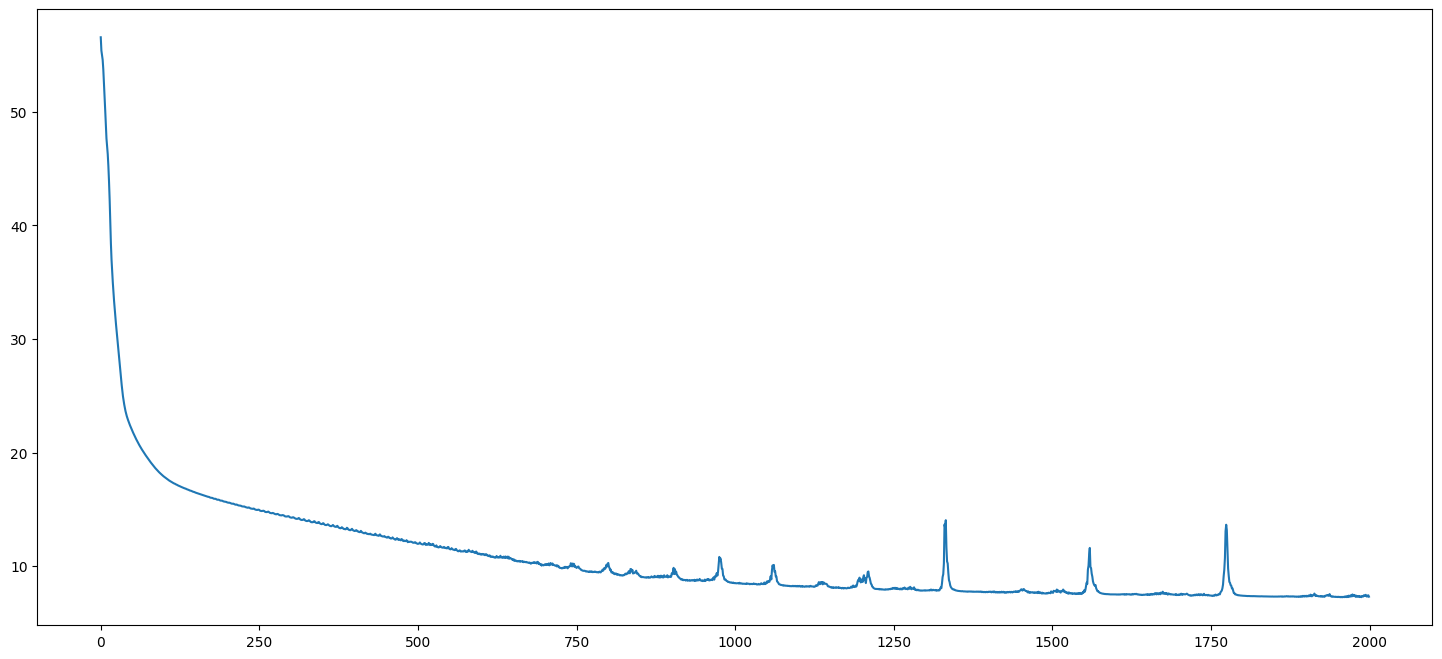

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(gpcnn_loss);

La calidad de las muestras dependera del tiempo de entrenamiento y el tamaño de la red, obviamente

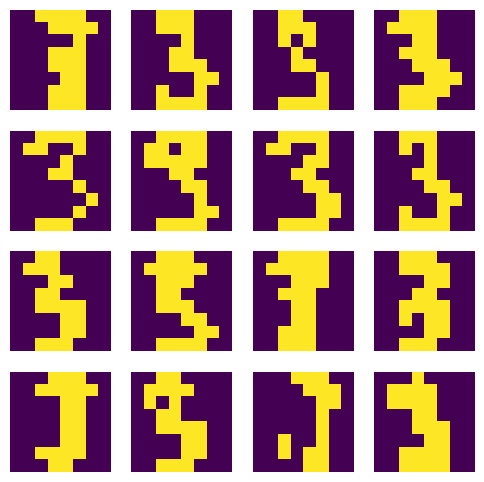

In [ ]:
nim = 4
gpcnn_samp=gpcnn_model.sample(n_samples=nim*nim)
fig = plt.figure(figsize=(6,6))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(gpcnn_samp[i].cpu().permute(1,2,0))
    plt.axis('off')

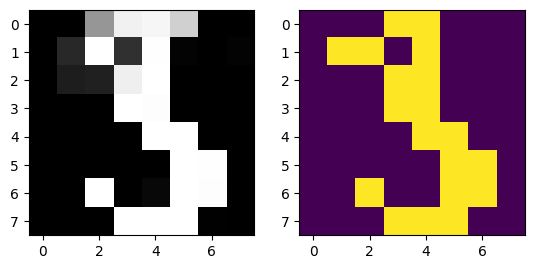

In [ ]:
lg = torch.sigmoid(gpcnn_model(torch.tensor(Xb[0].reshape((-1,8,8)), dtype=torch.float32).unsqueeze(1).to(device)).detach())

plt.subplot(1, 2, 1)
plt.imshow(lg.squeeze(1).cpu().permute(1,2,0),cmap='gray');
plt.subplot(1, 2, 2)
plt.imshow(Xb[0].reshape(8,8));

In [ ]:
def nll2(model, samp):
    epsilon =1e-15
    snll = 0.0
    for i in range(samp.shape[0]):
        mu = torch.sigmoid(model(samp[i].unsqueeze(1)).detach())
        snll += ((samp[i] * torch.log(mu+epsilon)) + ((1-samp[i]) * torch.log(1-mu+epsilon))).sum()
    return -snll.cpu()

nll2(gpcnn_model, torch.tensor(Xb[:100].reshape((-1,8,8)), dtype=torch.float32).unsqueeze(1).to(device))

tensor(605.1003)

La NLL no parece tan buena, es posible que la red necesite una exploracion mas exhaustiva de hiperparametros y algo más de paciencia (probablemente aumentando el parametro `n_gates` a 6 :-)

# Image GPT

Image GPT utiliza la arquitectura transformer como modelo autoregresivo, esta trabaja con un embedding de la imagen y predice el siguiente token  dada una secuencia de tokens. La arquitectura tiene solo el decoder de la arquitectura transformer.

Esta implementacion trabaja a nivel de pixel. La entrada es transformada a una secuencia que es pasada por diferentes capas transformer hasta generar el siguiente pixel.

La arquitectura define el numero de bloques transformer (n_transformer_blocks), el numero de cabezas del transformer (n_attention_heads, ha de ser un divisor del tamaño de la entrada) y el numero de canales que se usan en el embedding del transformer (n_embedding_channels).

Los parámetros por supuesto se han decidido también mágicamente.

In [ ]:
igpt_model = models.ImageGPT(in_channels=1, out_channels=1, in_size=8,
        n_transformer_blocks=3,
        n_attention_heads=8,
        n_embedding_channels=8)
igpt_model.to(device)
optimizer = optim.Adam(igpt_model.parameters(), lr=5e-3)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.999)

In [ ]:
igpt_loss = train_loop(igpt_model, optimizer, scheduler, loss_fn, bindig_dl, epochs2)

loss: 6.7958:lr: 6.7600E-04: 100%|██████████| 2000/2000 [02:21<00:00, 14.17it/s]


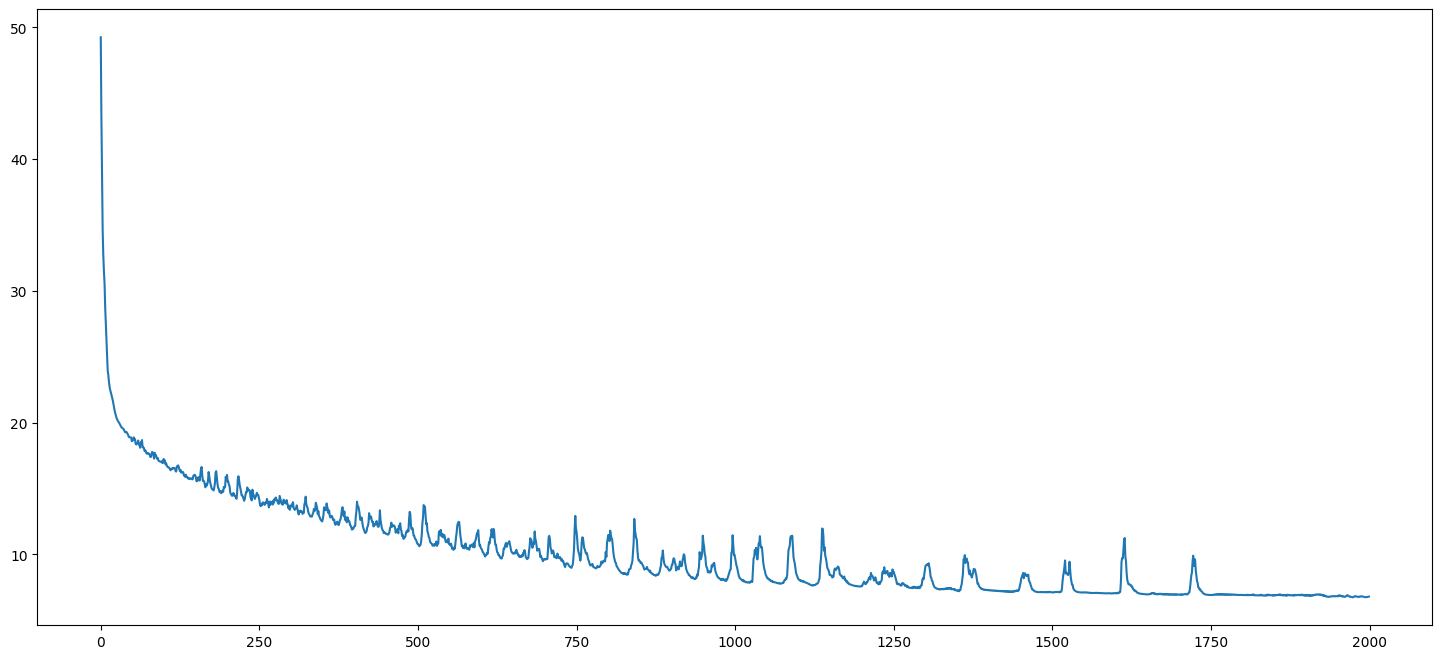

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(igpt_loss);

Las muestras parecen algo mejores (?)

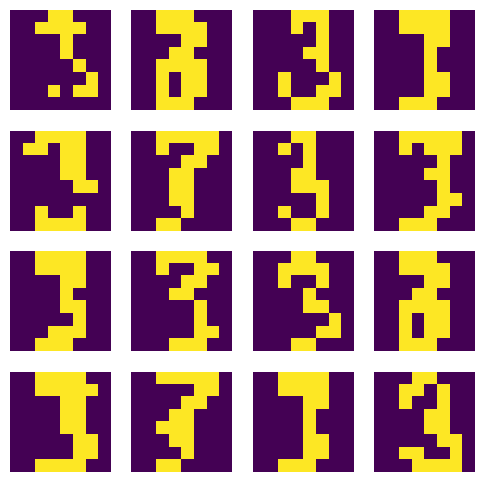

In [ ]:
nim = 4
pcnn_samp=igpt_model.sample(n_samples=nim*nim)
fig = plt.figure(figsize=(6,6))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(pcnn_samp[i].cpu().permute(1,2,0))
    plt.axis('off')

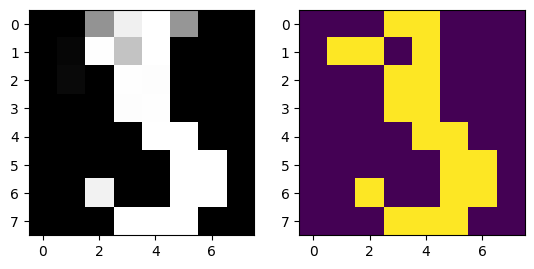

In [ ]:
lg = torch.sigmoid(igpt_model(torch.tensor(Xb[0].reshape((-1,8,8)), dtype=torch.float32).unsqueeze(1).to(device)).detach())

plt.subplot(1, 2, 1)
plt.imshow(lg.squeeze(1).cpu().permute(1,2,0),cmap='gray');
plt.subplot(1, 2, 2)
plt.imshow(Xb[0].reshape(8,8));

La NLL es mejor, requeriria una exploración de hiperparametros y un modelo de mas capacidad o quizar menos, una muestra de validación nos permitiria ver si se ha sobre especializado, otra vez ejercicio para el lector

In [ ]:
nll2(igpt_model, torch.tensor(Xb[:100].reshape((-1,8,8)), dtype=torch.float32).unsqueeze(1).to(device))

tensor(565.6711)

# Image GPT (Double down again)

Visto que este modelo puede obtener mejores resultados podemos comprobar si podemos generar los valores de los píxeles con esta arquitectura

In [ ]:
# Es la misma que antes, pero con un cambio para cuadrar con la implementacion de image GPT de la libreria
def loss_fn2(x, preds):
    batch_size = x.shape[0]
    x, preds = x.reshape((batch_size, -1)), preds.reshape((batch_size, -1))
    loss = F.binary_cross_entropy_with_logits(preds, x, reduction="none")
    return loss.sum(dim=1).mean()

In [ ]:
igpt2_model = models.ImageGPT(in_channels=17, out_channels=17, in_size=8,
        n_transformer_blocks=6,
        n_attention_heads=8,
        n_embedding_channels=16)
igpt2_model.to(device)
optimizer = optim.Adam(igpt2_model.parameters(), lr=1e-3)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.9999)

In [ ]:
igpt2_loss = train_loop(igpt2_model, optimizer, scheduler, loss_fn2, digits_dl, 3000)

loss: 20.3682:lr: 7.4081E-04: 100%|██████████| 3000/3000 [03:43<00:00, 13.45it/s]


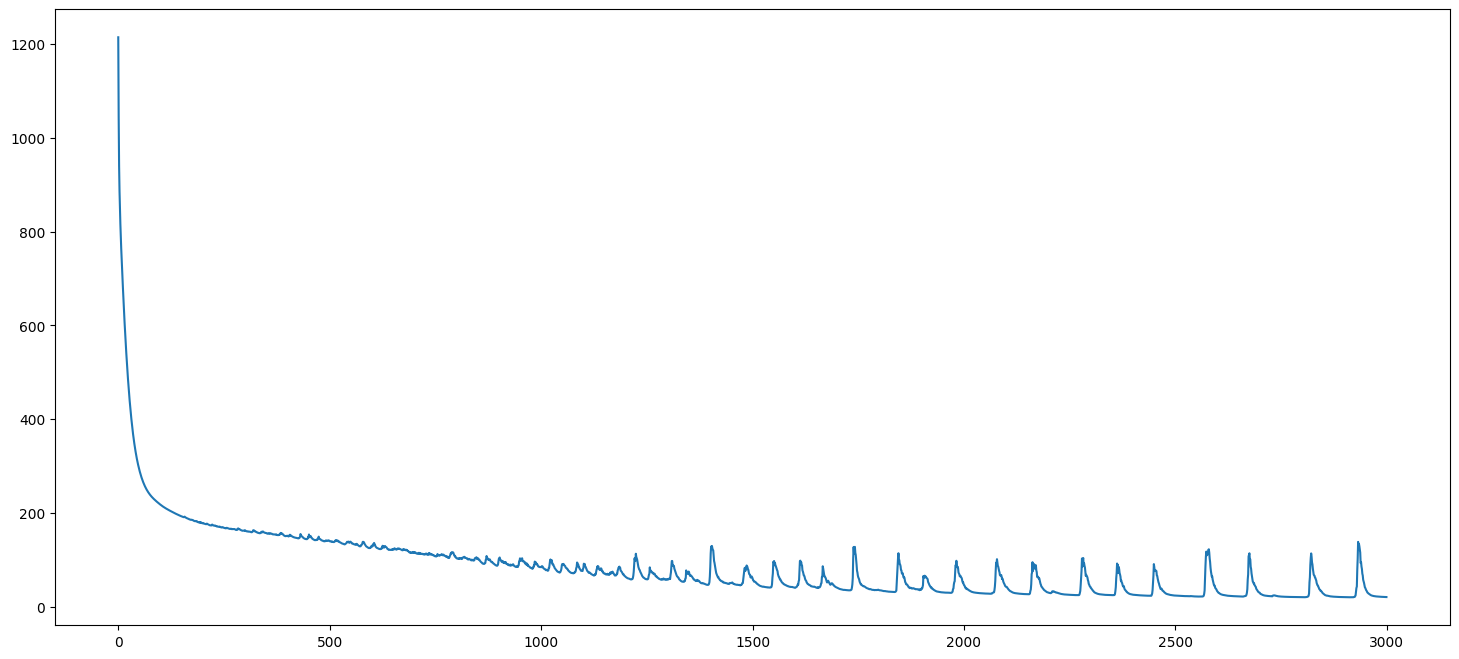

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(igpt2_loss);

y ahora las muestras deberían ser bastante más reconocibles que las generadas por pixelCNN

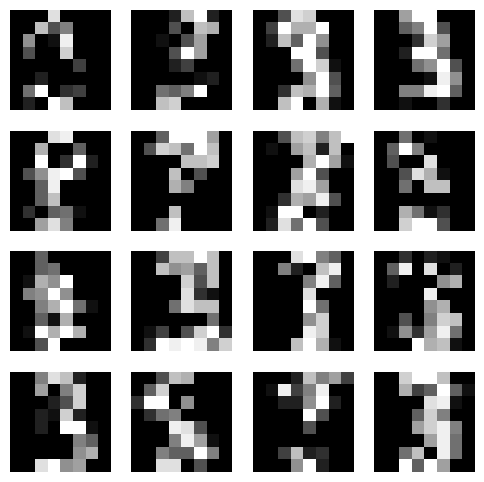

In [ ]:
nim = 4
igpt2_samp=igpt2_model.sample(n_samples=nim*nim)
fig = plt.figure(figsize=(6,6))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(np.argmax(igpt2_samp[i].cpu().numpy(), axis=0), cmap='gray')
    plt.axis('off')

In [ ]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

Total Running time 0:17:07.506607


---


<font color="red" size=6>
Ejercicio de laboratorio entregable
</font>



>Ya que hemos aprendido una distribución que corresponde a una clase, esta debería poder servir para detectar elementos que no pertenecen a la distribución.

>La propuesta de este ejercicio es calcular la NLL varios ejemplos del resto de las clases con MADE, pixelCNN e imageGPT y comprobar si les asignan una baja probabilidad y si digitos más parecidos al 0 tienen una probabilidad diferente de dígitos que no se le parecen.

> <font color="blue">
Haz un informe con lo que has hecho y los resultados. Explica tus conclusiones.</font>


---

In [ ]:
def nll(model, samp):
    epsilon = 1e-15
    snll = 0.0
    for i in range(samp.shape[0]):
        mu = torch.sigmoid(model(samp[i]).detach())
        snll += ((samp[i] * torch.log(mu+epsilon)) + ((1-samp[i]) * torch.log(1-mu+epsilon))).sum()
    return -snll.cpu()

def nll2(model, samp):
    epsilon =1e-15
    snll = 0.0
    for i in range(samp.shape[0]):
        mu = torch.sigmoid(model(samp[i].unsqueeze(1)).detach())
        snll += ((samp[i] * torch.log(mu+epsilon)) + ((1-samp[i]) * torch.log(1-mu+epsilon))).sum()
    return -snll.cpu()

models = {"MADE model": made_model, "Pixel CNN": pcnn_model, "Image GPT": igpt_model, "Gated Pixel CNN": gpcnn_model} #"Pixel CNN double down": pcnn2_model, "Image GPT double down": igpt2_model

results = {name: [] for name in models}
for name, model in models.items():
  print (f"Model {name}")
  for i in range(10):
    Xo,y =  load_digits(n_class=10, return_X_y=True)
    X1 = Xo[y==i]
    Xb1 = Binarizer(threshold=7).fit_transform(X1)
    if name not in ["Pixel CNN double down", "Image GPT double down", "Gated Pixel CNN"]:
      result = nll(model, torch.tensor(Xb1[:100].reshape((-1,8,8)), dtype=torch.float32).unsqueeze(1).to(device))
    else:
      result = nll2(model, torch.tensor(Xb1[:100].reshape((-1,8,8)), dtype=torch.float32).unsqueeze(1).to(device))
    results[name].append(float(result))
    print(f"NLL for class {i}: {result}")



Model MADE model
NLL for class 0: 27258.66796875
NLL for class 1: 19077.955078125
NLL for class 2: 22737.587890625
NLL for class 3: 606.4548950195312
NLL for class 4: 29489.203125
NLL for class 5: 17851.572265625
NLL for class 6: 24018.0625
NLL for class 7: 21891.1171875
NLL for class 8: 16276.1025390625
NLL for class 9: 15815.3408203125
Model Pixel CNN
NLL for class 0: 6899.3896484375
NLL for class 1: 4390.8310546875
NLL for class 2: 5341.818359375
NLL for class 3: 1176.136474609375
NLL for class 4: 7751.83349609375
NLL for class 5: 5467.451171875
NLL for class 6: 6909.7119140625
NLL for class 7: 4436.56494140625
NLL for class 8: 4551.40087890625
NLL for class 9: 4868.673828125
Model Image GPT
NLL for class 0: 12396.7890625
NLL for class 1: 12647.251953125
NLL for class 2: 12934.8505859375
NLL for class 3: 565.6710815429688
NLL for class 4: 18018.16015625
NLL for class 5: 11280.5673828125
NLL for class 6: 13266.32421875
NLL for class 7: 11572.046875
NLL for class 8: 11220.984375
NLL f

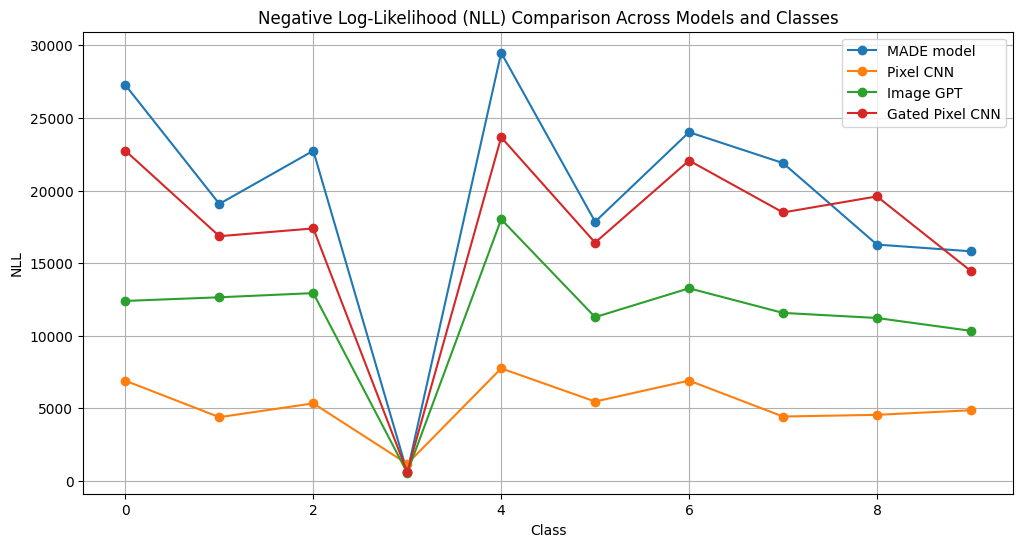

In [ ]:
plt.figure(figsize=(12, 6))
for name, nll_values in results.items():
    plt.plot(range(10), nll_values, marker='o', label=name)

plt.title("Negative Log-Likelihood (NLL) Comparison Across Models and Classes")
plt.xlabel("Class")
plt.ylabel("NLL")
plt.legend()
plt.grid(True)
plt.show()


Model MADE model
Class 0 - Lowest NLL samples: [61, 63, 20, 25, 41]
Class 1 - Lowest NLL samples: [80, 70, 40, 79, 51]
Class 2 - Lowest NLL samples: [42, 76, 71, 60, 72]
Class 3 - Lowest NLL samples: [77, 16, 93, 51, 43]
Class 4 - Lowest NLL samples: [47, 50, 38, 8, 16]
Class 5 - Lowest NLL samples: [8, 16, 81, 30, 95]
Class 6 - Lowest NLL samples: [47, 51, 41, 45, 40]
Class 7 - Lowest NLL samples: [30, 81, 63, 3, 91]
Class 8 - Lowest NLL samples: [80, 87, 4, 75, 92]
Class 9 - Lowest NLL samples: [46, 94, 50, 27, 15]
Model Pixel CNN
Class 0 - Lowest NLL samples: [56, 72, 26, 62, 9]
Class 1 - Lowest NLL samples: [78, 80, 82, 81, 84]
Class 2 - Lowest NLL samples: [72, 70, 12, 87, 90]
Class 3 - Lowest NLL samples: [16, 39, 33, 93, 88]
Class 4 - Lowest NLL samples: [5, 11, 6, 7, 16]
Class 5 - Lowest NLL samples: [29, 2, 77, 10, 27]
Class 6 - Lowest NLL samples: [11, 41, 38, 84, 39]
Class 7 - Lowest NLL samples: [18, 81, 3, 60, 50]
Class 8 - Lowest NLL samples: [84, 87, 85, 10, 86]
Class 9 

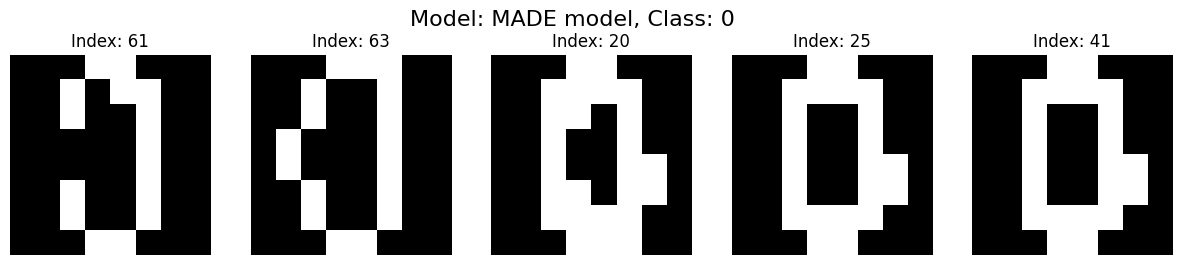

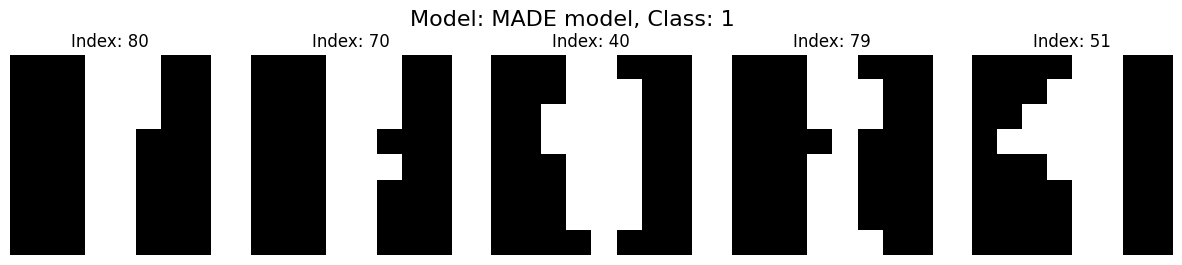

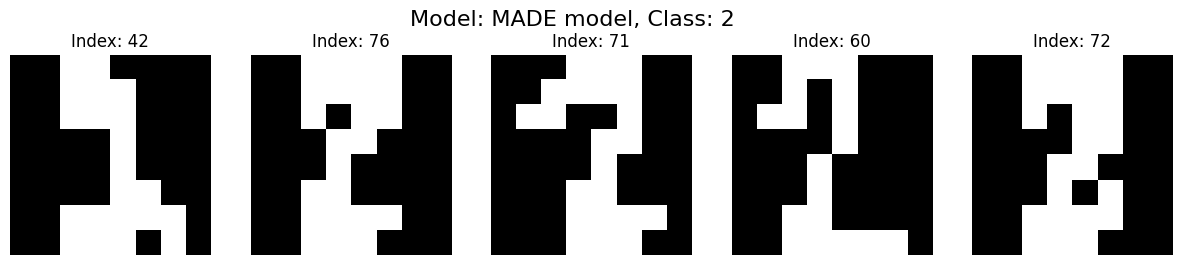

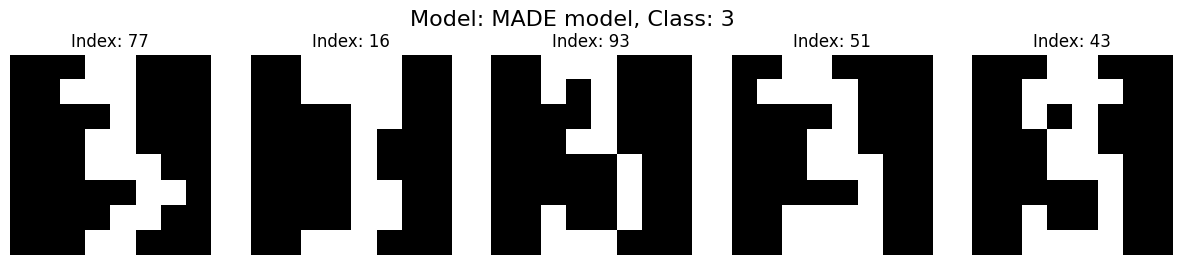

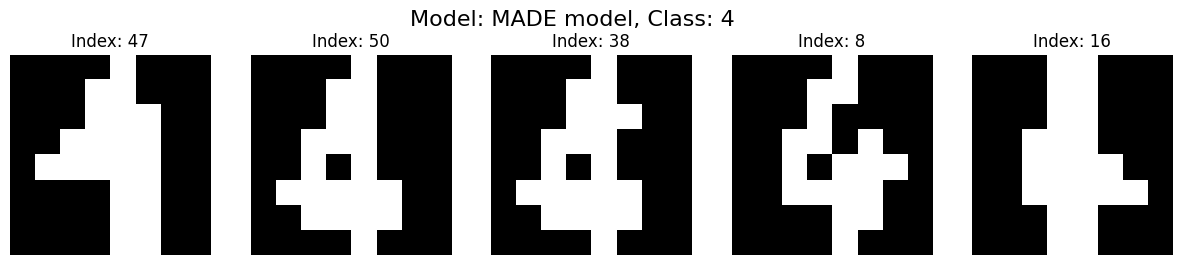

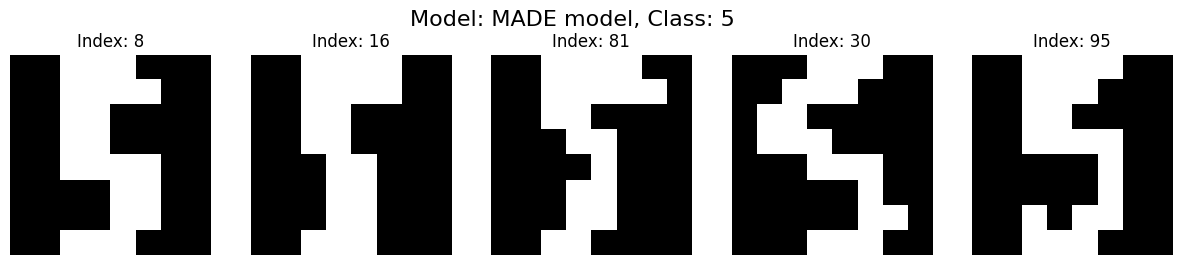

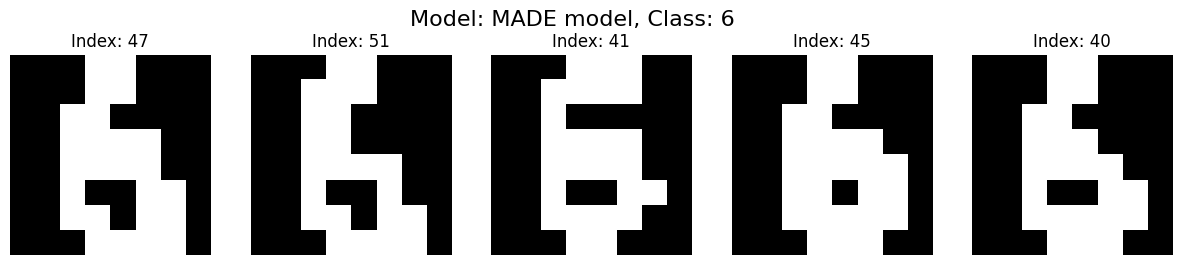

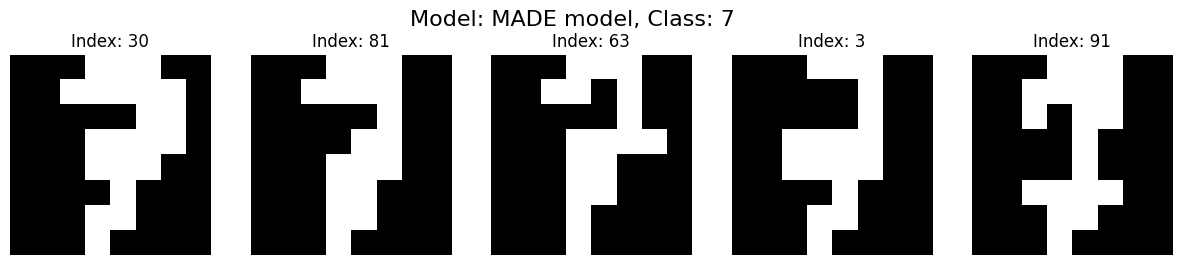

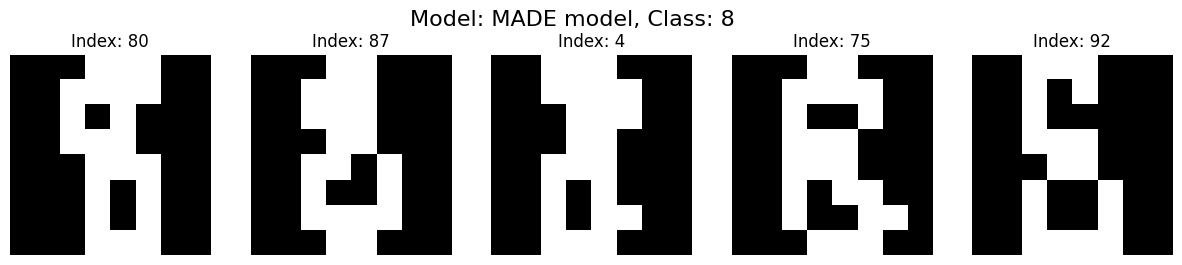

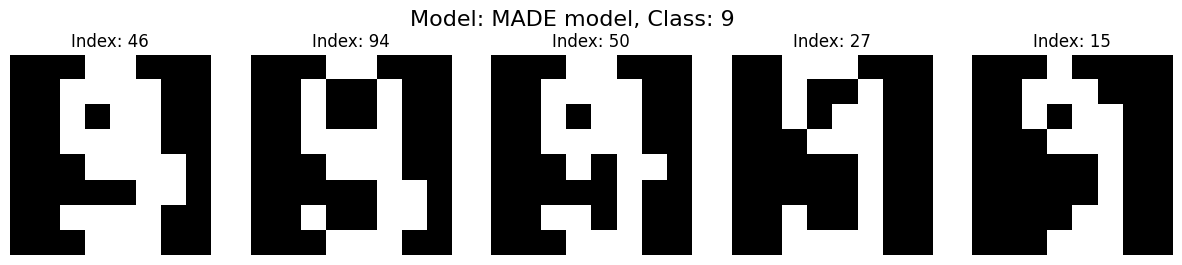


Visualizing results for Pixel CNN


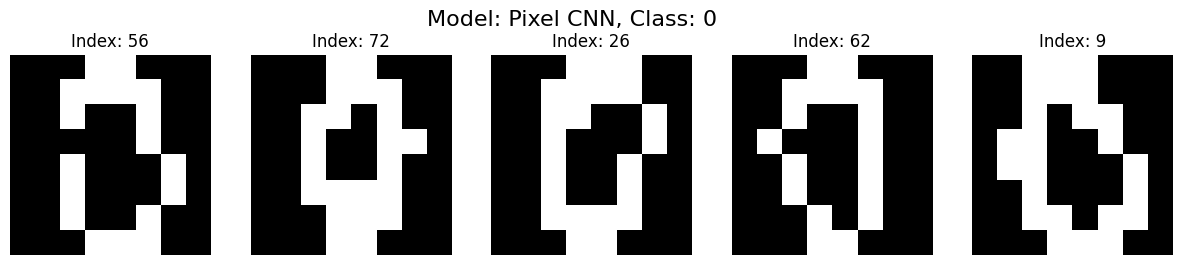

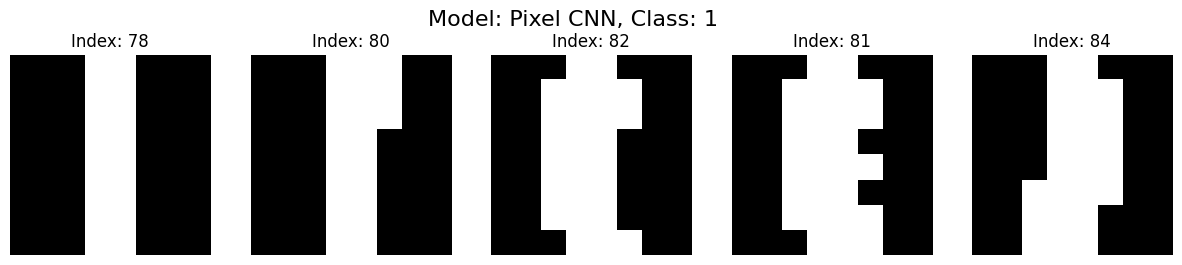

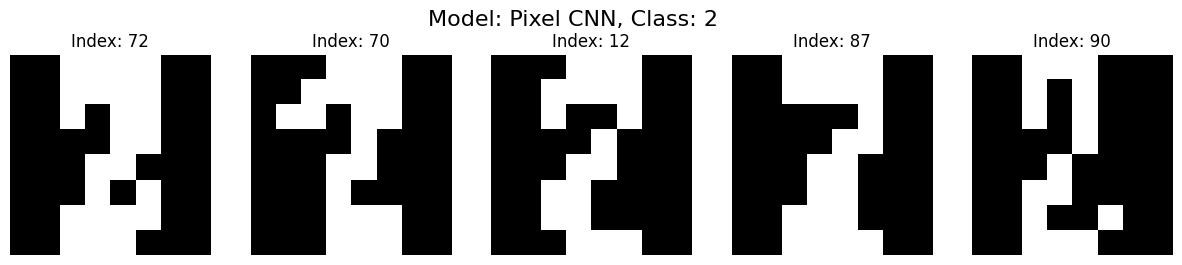

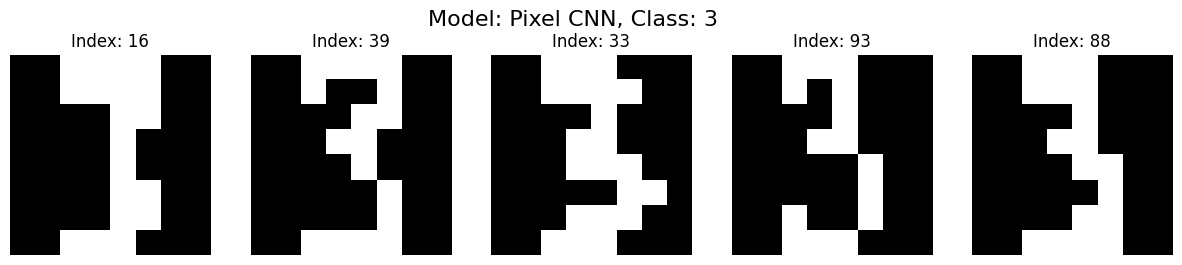

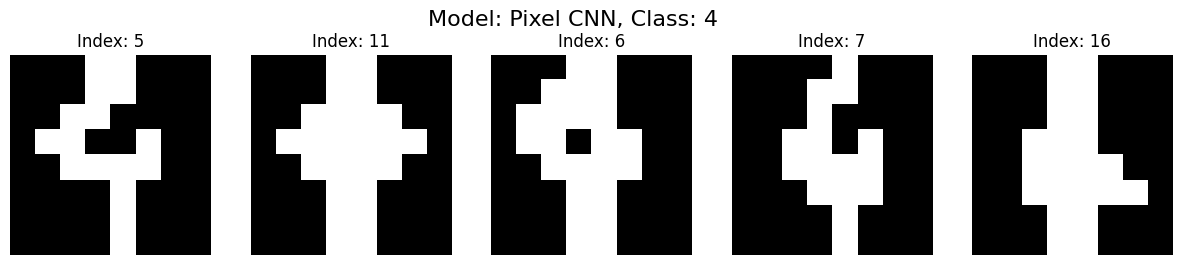

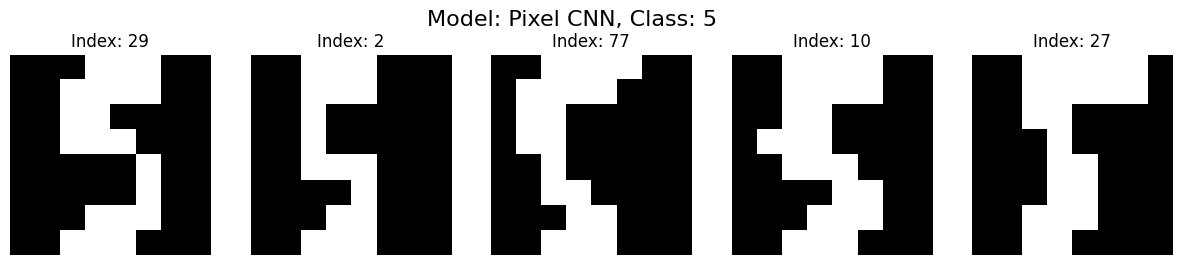

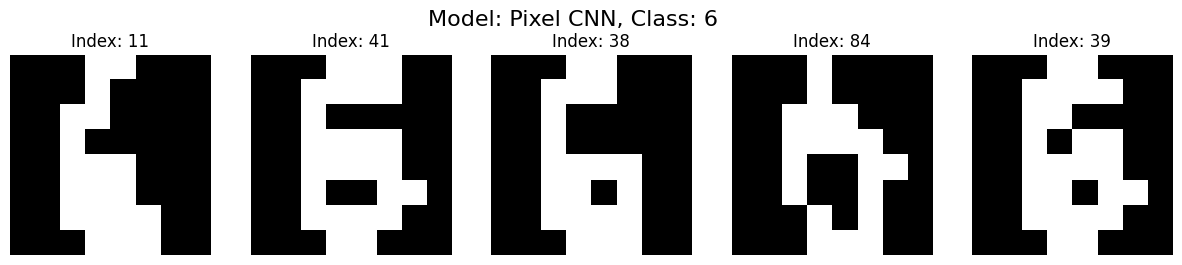

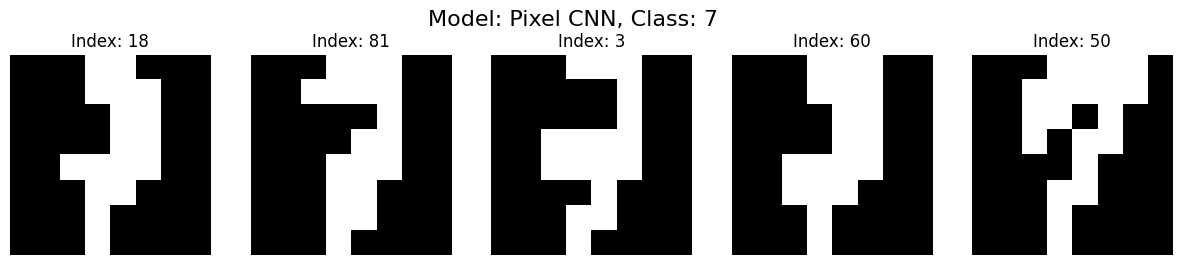

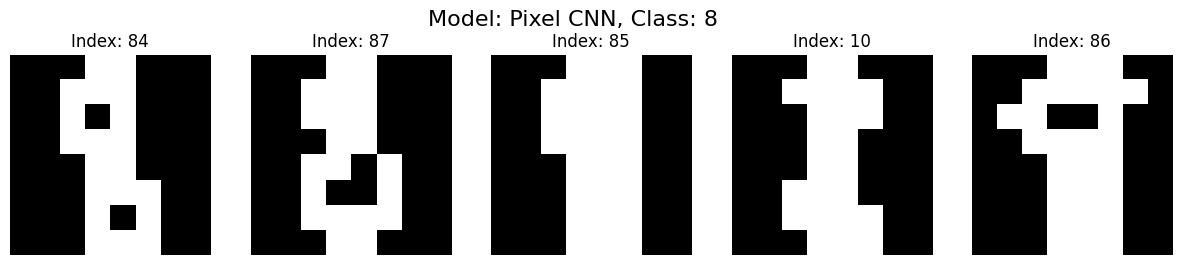

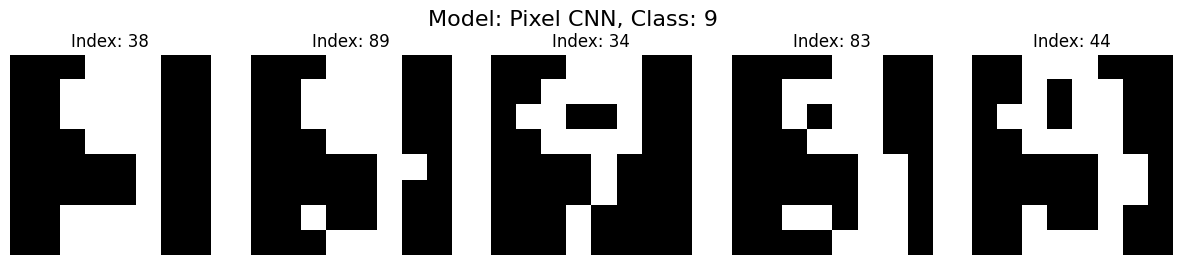


Visualizing results for Image GPT


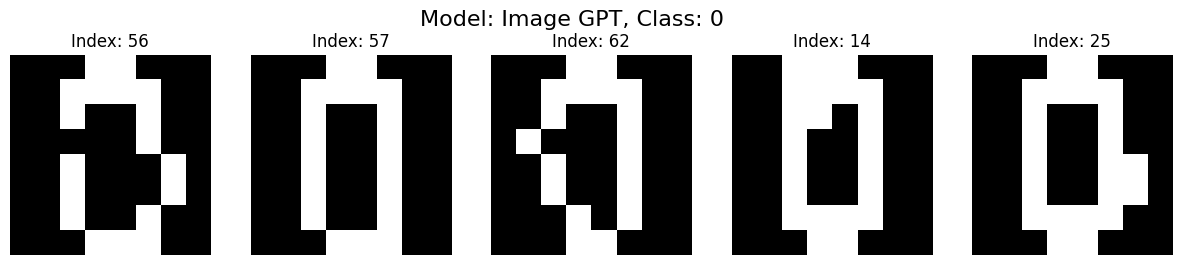

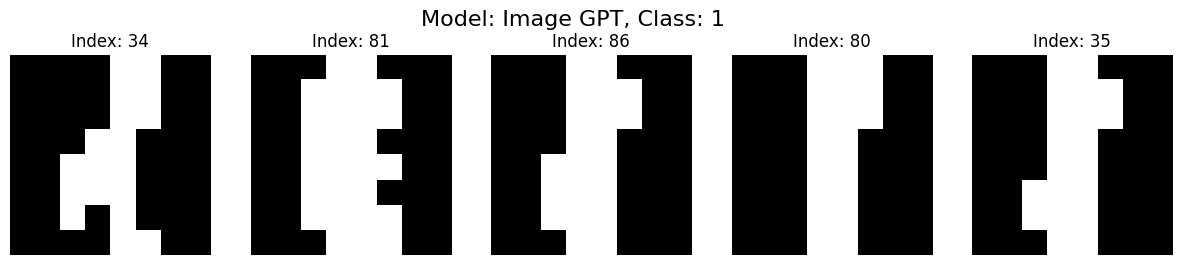

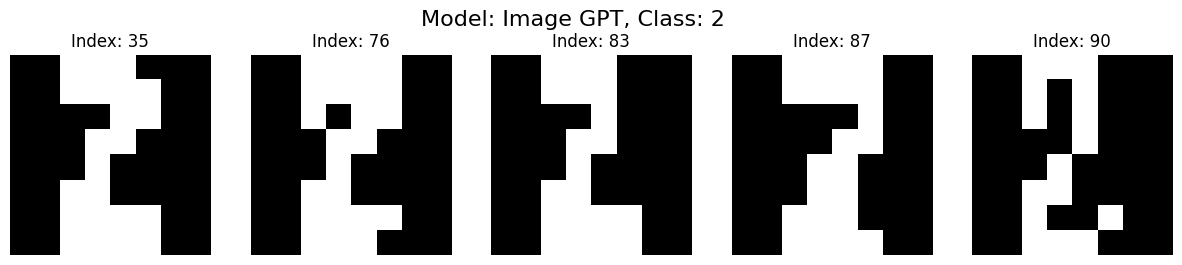

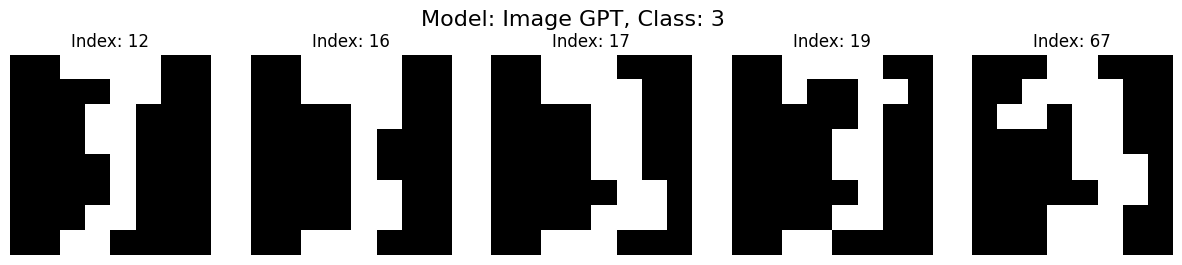

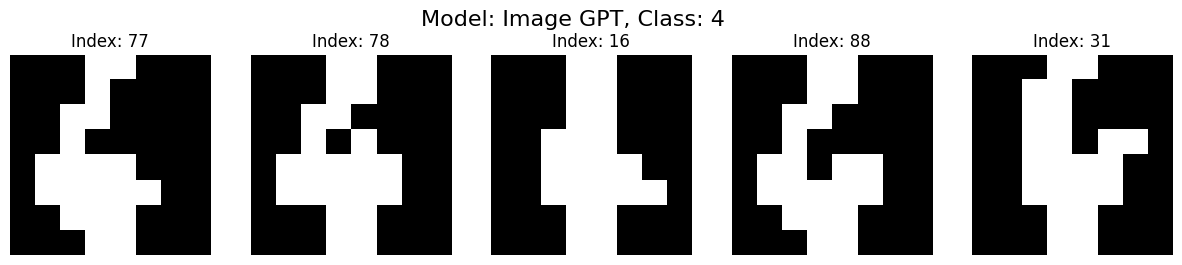

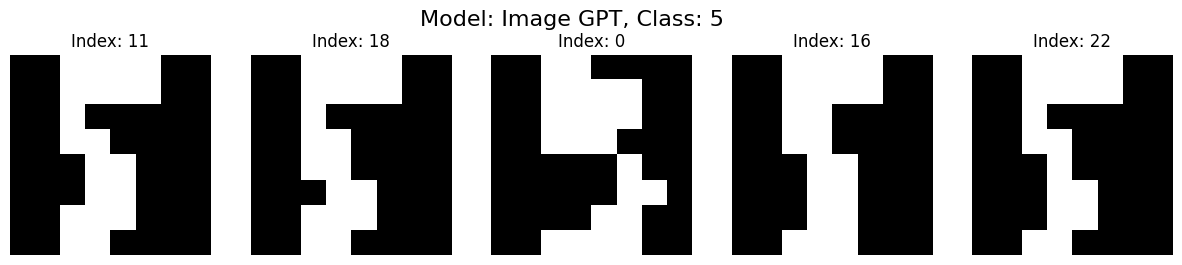

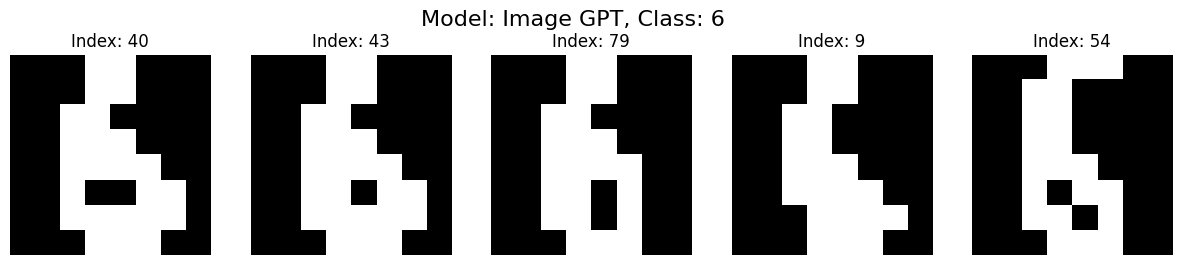

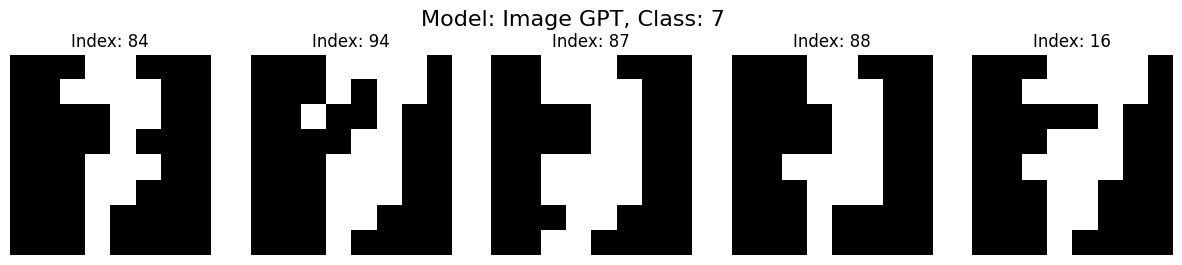

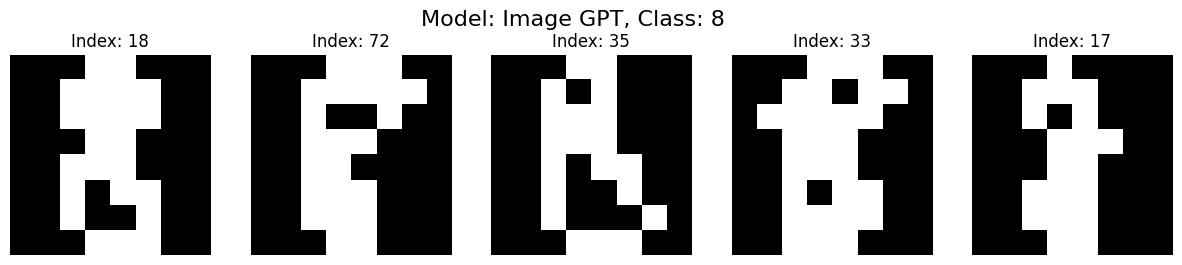

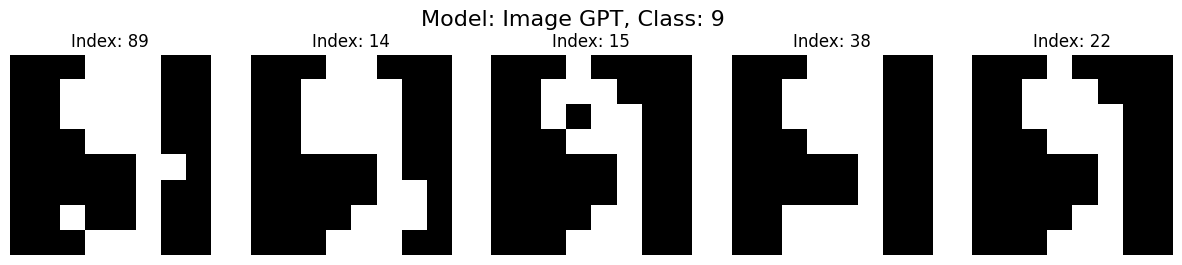


Visualizing results for Gated Pixel CNN


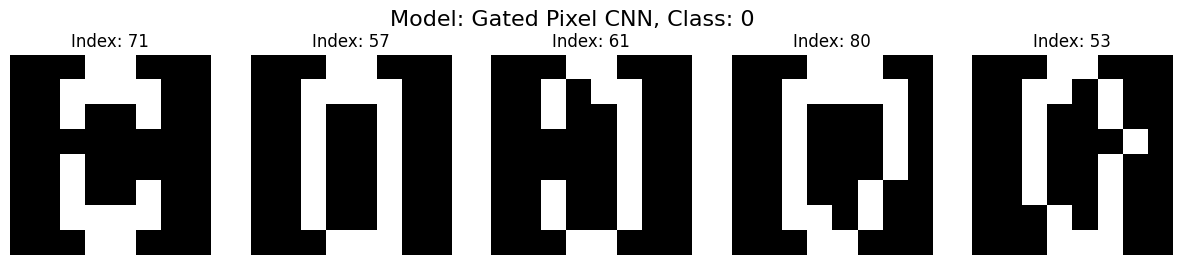

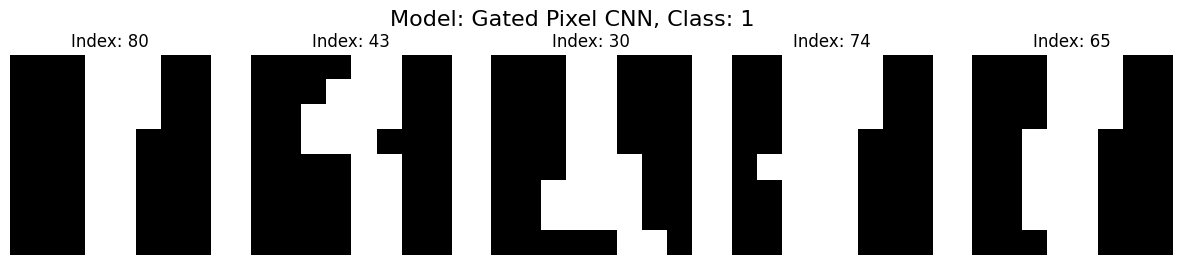

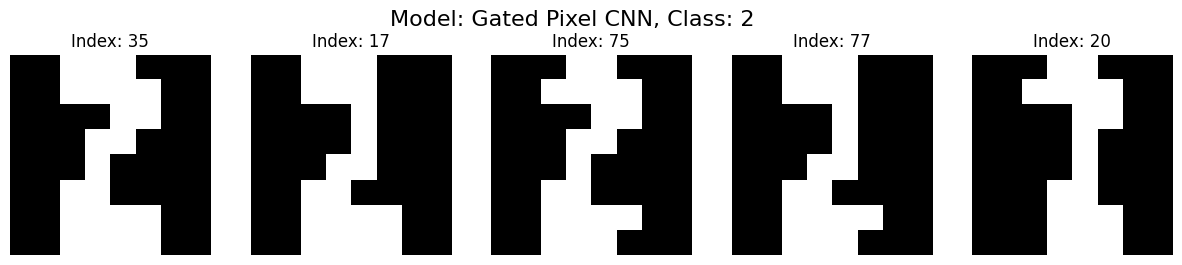

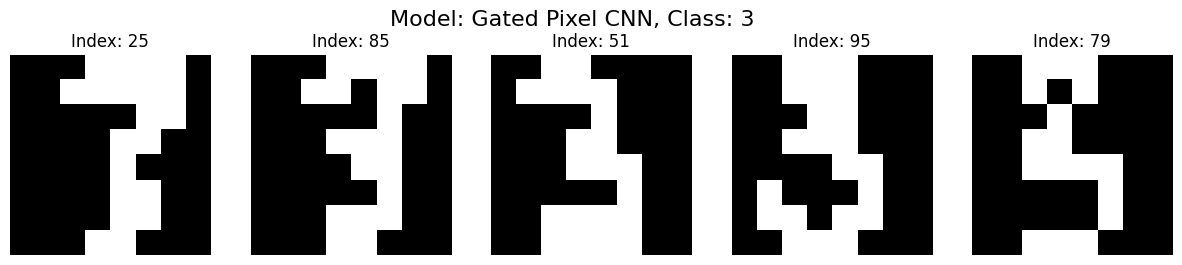

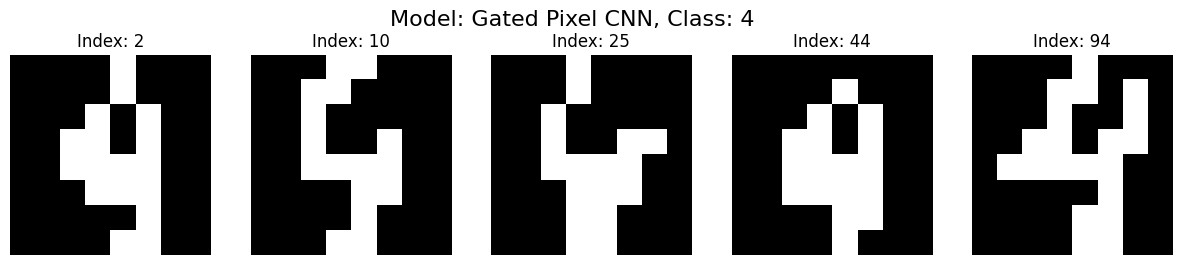

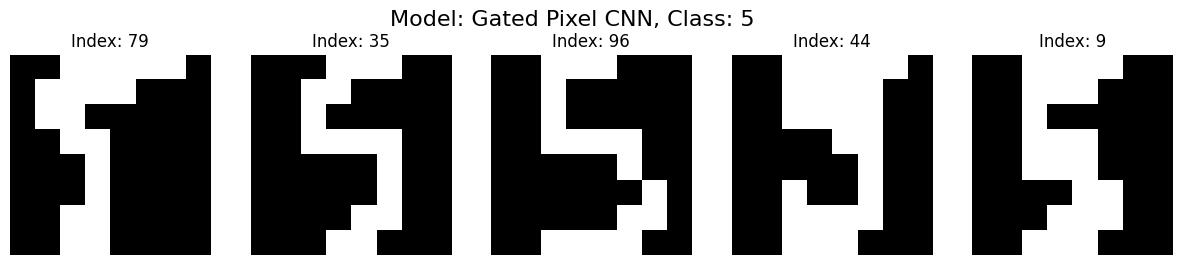

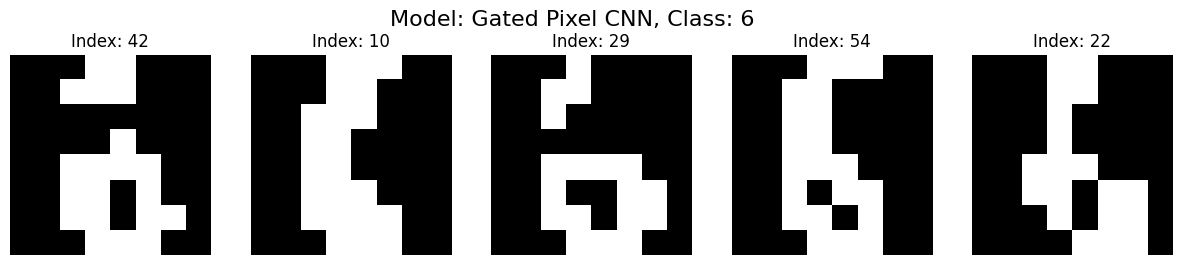

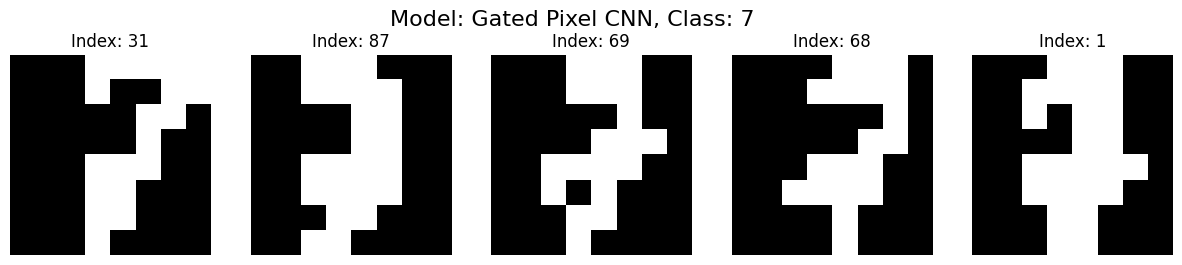

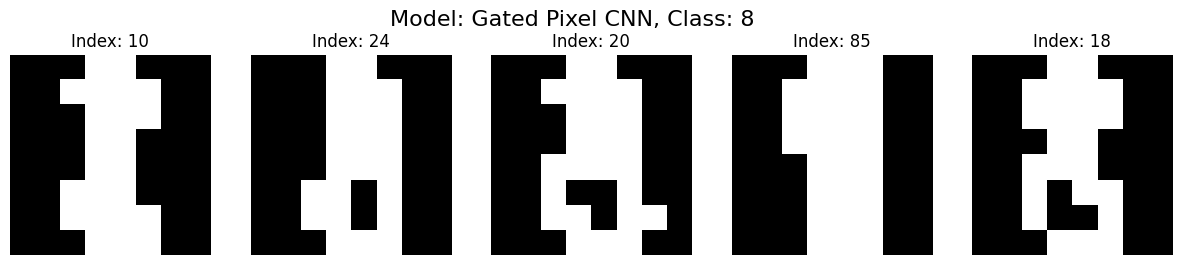

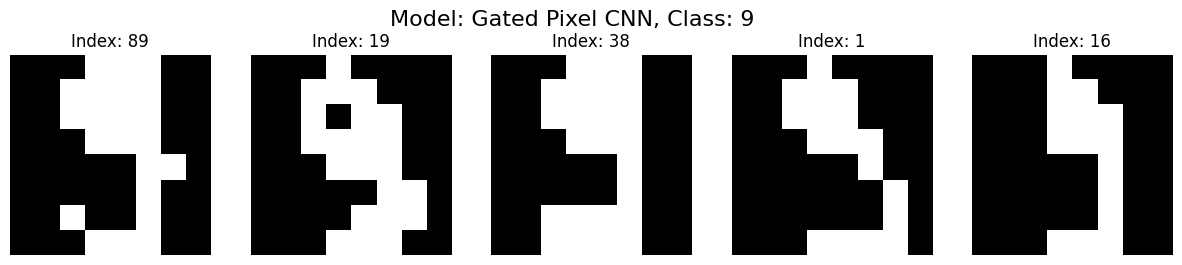

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import Binarizer
import torch

# Modified nll functions to return per-sample NLLs
def nll_per_sample(model, samp):
    epsilon = 1e-15
    nll_values = []
    for i in range(samp.shape[0]):
        mu = torch.sigmoid(model(samp[i]).detach())
        nll = -((samp[i] * torch.log(mu + epsilon)) + ((1 - samp[i]) * torch.log(1 - mu + epsilon))).sum()
        nll_values.append(nll.cpu().item())
    return nll_values

def nll2_per_sample(model, samp):
    epsilon = 1e-15
    nll_values = []
    for i in range(samp.shape[0]):
        mu = torch.sigmoid(model(samp[i].unsqueeze(1)).detach())
        nll = -((samp[i] * torch.log(mu + epsilon)) + ((1 - samp[i]) * torch.log(1 - mu + epsilon))).sum()
        nll_values.append(nll.cpu().item())
    return nll_values

# Storing results
models = {"MADE model": made_model, "Pixel CNN": pcnn_model, "Image GPT": igpt_model, "Gated Pixel CNN": gpcnn_model}
results = {name: [] for name in models}
low_nll_examples = {name: [] for name in models}

for name, model in models.items():
    print(f"Model {name}")
    for i in range(10):
        Xo, y = load_digits(n_class=10, return_X_y=True)
        X1 = Xo[y == i]
        Xb1 = Binarizer(threshold=7).fit_transform(X1)

        # Reshape and calculate NLL per sample
        inputs = torch.tensor(Xb1[:100].reshape((-1, 8, 8)), dtype=torch.float32).unsqueeze(1).to(device)
        if name not in ["Pixel CNN double down", "Image GPT double down", "Gated Pixel CNN"]:
            nll_values = nll_per_sample(model, inputs)
        else:
            nll_values = nll2_per_sample(model, inputs)

        # Store results
        results[name].extend(nll_values)
        # Get indices of samples with the lowest NLLs
        low_nll_indices = sorted(range(len(nll_values)), key=lambda x: nll_values[x])[:5]  # Top 5 lowest NLLs
        low_nll_examples[name].append((i, low_nll_indices, Xb1[low_nll_indices]))
        print(f"Class {i} - Lowest NLL samples: {low_nll_indices}")

# Visualization
for name, examples in low_nll_examples.items():
    print(f"\nVisualizing results for {name}")
    for cls, indices, samples in examples:
        fig, axs = plt.subplots(1, len(samples), figsize=(15, 3))
        fig.suptitle(f"Model: {name}, Class: {cls}", fontsize=16)
        for idx, ax in enumerate(axs):
            ax.imshow(samples[idx].reshape(8, 8), cmap="gray")
            ax.axis("off")
            ax.set_title(f"Index: {indices[idx]}")
        plt.show()


Training MADE for extra epochs...


loss: 7.2003:lr: 6.7031E-04: 100%|██████████| 1000/1000 [00:17<00:00, 56.80it/s]


Training PixelCNN for extra epochs...


loss: 13.9065:lr: 6.0652E-04: 100%|██████████| 1000/1000 [00:26<00:00, 37.20it/s]


Training ImageGPT for extra epochs...


loss: 6.6992:lr: 5.4880E-04: 100%|██████████| 1000/1000 [01:08<00:00, 14.65it/s]


MADE Final NLL: 606.4549
PixelCNN Final NLL: 1176.1365
ImageGPT Final NLL: 565.6711
Generating samples from MADE...
Generating samples from PixelCNN...
Generating samples from ImageGPT...


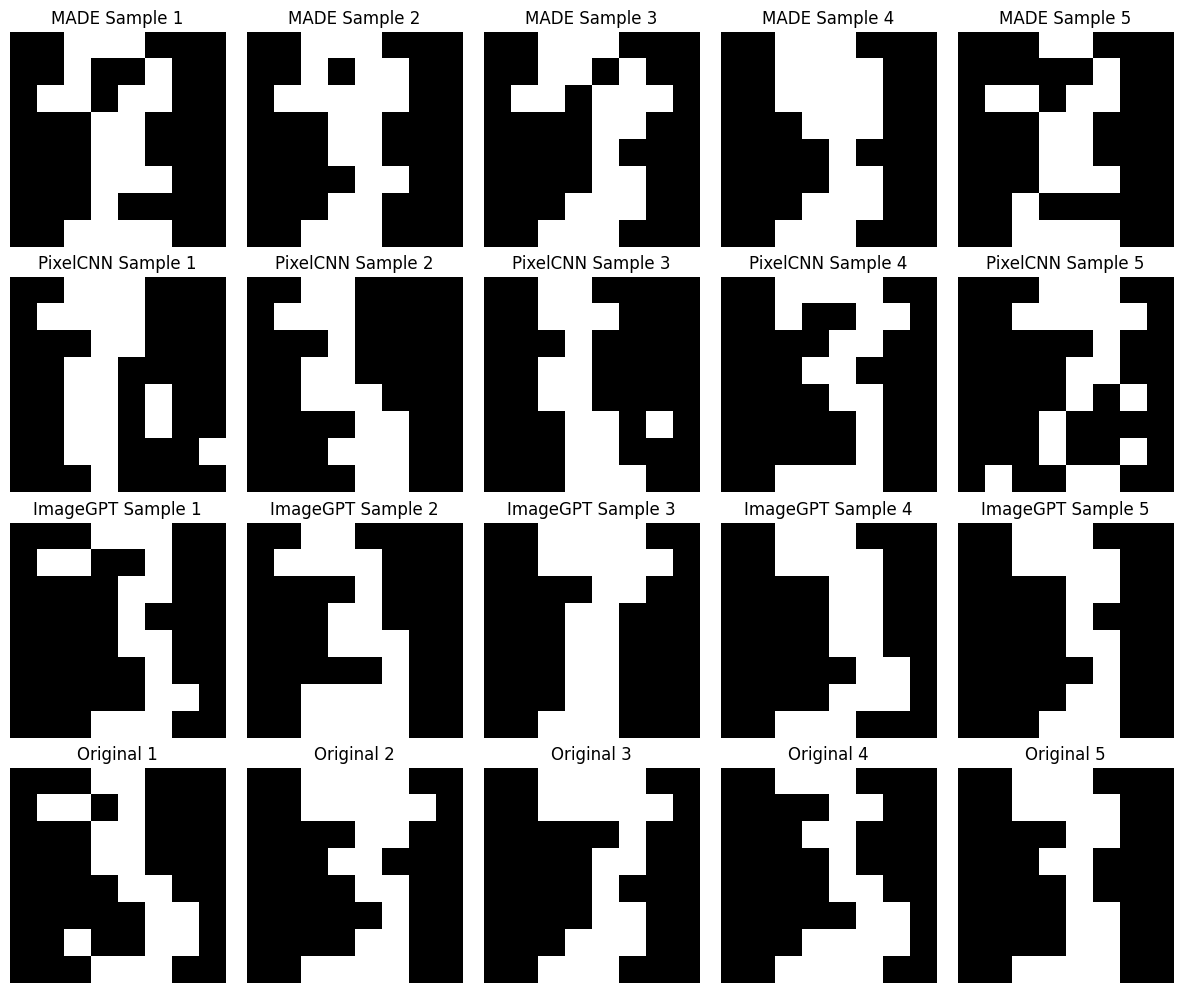

In [ ]:
# Training each model for a few more epochs for better results
extra_epochs = 1000

print("Training MADE for extra epochs...")
made_loss_extra = train_loop(made_model, optimizer, scheduler, loss_fn, bindig_dl, extra_epochs)
print("Training PixelCNN for extra epochs...")
pcnn_loss_extra = train_loop(pcnn_model, optimizer, scheduler, loss_fn, bindig_dl, extra_epochs)
print("Training ImageGPT for extra epochs...")
igpt_loss_extra = train_loop(igpt_model, optimizer, scheduler, loss_fn, bindig_dl, extra_epochs)

# Final negative log-likelihood (NLL) comparison
nll_made = nll(made_model, torch.tensor(Xb[:100].reshape((-1, 8, 8)), dtype=torch.float32).unsqueeze(1).to(device))
nll_pcnn = nll2(pcnn_model, torch.tensor(Xb[:100].reshape((-1, 8, 8)), dtype=torch.float32).unsqueeze(1).to(device))
nll_igpt = nll2(igpt_model, torch.tensor(Xb[:100].reshape((-1, 8, 8)), dtype=torch.float32).unsqueeze(1).to(device))

print(f"MADE Final NLL: {nll_made:.4f}")
print(f"PixelCNN Final NLL: {nll_pcnn:.4f}")
print(f"ImageGPT Final NLL: {nll_igpt:.4f}")

# Generate samples from the models
def generate_samples(model, num_samples=5, image_shape=(8, 8)):
    model.eval()
    samples = []
    for _ in range(num_samples):
        sample = torch.zeros((1, 1, *image_shape), device=device)
        for i in range(image_shape[0]):
            for j in range(image_shape[1]):
                logits = model(sample).detach()
                probs = torch.sigmoid(logits)
                sample[:, :, i, j] = torch.bernoulli(probs[:, :, i, j])
        samples.append(sample.squeeze().cpu().numpy())
    return samples

print("Generating samples from MADE...")
made_samples = generate_samples(made_model, num_samples=5)
print("Generating samples from PixelCNN...")
pcnn_samples = generate_samples(pcnn_model, num_samples=5)
print("Generating samples from ImageGPT...")
igpt_samples = generate_samples(igpt_model, num_samples=5)

# Visualizing generated samples alongside original samples
fig, axs = plt.subplots(4, 5, figsize=(12, 10))
for i, sample in enumerate(made_samples):
    axs[0, i].imshow(sample, cmap="gray")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"MADE Sample {i+1}")

for i, sample in enumerate(pcnn_samples):
    axs[1, i].imshow(sample, cmap="gray")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"PixelCNN Sample {i+1}")

for i, sample in enumerate(igpt_samples):
    axs[2, i].imshow(sample, cmap="gray")
    axs[2, i].axis("off")
    axs[2, i].set_title(f"ImageGPT Sample {i+1}")

# Display original binarized samples
for i in range(5):
    axs[3, i].imshow(Xb[i].reshape(8, 8), cmap="gray")
    axs[3, i].axis("off")
    axs[3, i].set_title(f"Original {i+1}")

plt.tight_layout()
plt.show()


In [ ]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

def calculate_similarity(original, generated):
    mse_scores = []
    ssim_scores = []
    for orig, gen in zip(original, generated):
        mse_scores.append(mean_squared_error(orig.flatten(), gen.flatten()))
        ssim_scores.append(ssim(orig, gen, data_range=gen.max() - gen.min()))
    return np.mean(mse_scores), np.mean(ssim_scores)

# Convert original samples to proper format
original_images = [Xb[i].reshape(8, 8) for i in range(5)]

# Compare MADE, PixelCNN, and ImageGPT samples
mse_made, ssim_made = calculate_similarity(original_images, made_samples)
mse_pcnn, ssim_pcnn = calculate_similarity(original_images, pcnn_samples)
mse_igpt, ssim_igpt = calculate_similarity(original_images, igpt_samples)

print(f"MADE Similarity -> MSE: {mse_made:.4f}, SSIM: {ssim_made:.4f}")
print(f"PixelCNN Similarity -> MSE: {mse_pcnn:.4f}, SSIM: {ssim_pcnn:.4f}")
print(f"ImageGPT Similarity -> MSE: {mse_igpt:.4f}, SSIM: {ssim_igpt:.4f}")


MADE Similarity -> MSE: 0.1844, SSIM: 0.5063
PixelCNN Similarity -> MSE: 0.2531, SSIM: 0.3456
ImageGPT Similarity -> MSE: 0.1094, SSIM: 0.7049


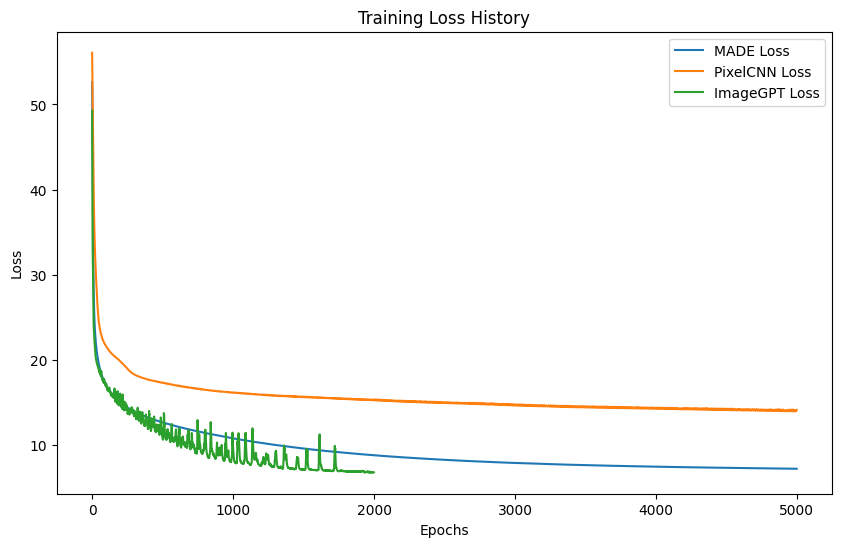


Final Comparison Report:
MADE - NLL: 606.4549, MSE: 0.1844, SSIM: 0.5063
PixelCNN - NLL: 1176.1365, MSE: 0.2531, SSIM: 0.3456
ImageGPT - NLL: 565.6711, MSE: 0.1094, SSIM: 0.7049


In [ ]:
# Combine loss history for final visualization
plt.figure(figsize=(10, 6))
plt.plot(made_loss, label="MADE Loss")
plt.plot(pcnn_loss, label="PixelCNN Loss")
plt.plot(igpt_loss, label="ImageGPT Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.show()

# Final Report Summary
print("\nFinal Comparison Report:")
print(f"MADE - NLL: {nll_made:.4f}, MSE: {mse_made:.4f}, SSIM: {ssim_made:.4f}")
print(f"PixelCNN - NLL: {nll_pcnn:.4f}, MSE: {mse_pcnn:.4f}, SSIM: {ssim_pcnn:.4f}")
print(f"ImageGPT - NLL: {nll_igpt:.4f}, MSE: {mse_igpt:.4f}, SSIM: {ssim_igpt:.4f}")


In [ ]:
# Load full digits dataset (0–9)
X_full, y_full = load_digits(n_class=10, return_X_y=True)

# Binarize data for consistency
Xb_full = Binarizer(threshold=7).fit_transform(X_full)

# Split data by digits
class_data = {digit: Xb_full[y_full == digit] for digit in range(10)}
datasets = {digit: BinDigits(data) for digit, data in class_data.items()}
data_loaders = {digit: torch.utils.data.DataLoader(ds, batch_size=32) for digit, ds in datasets.items()}


In [ ]:
# Evaluate NLL and similarity for each digit
digit_nlls = {}
digit_similarities = {}

for digit in range(10):
    # Get dataset and dataloader
    test_loader = data_loaders[digit]

    # Compute NLL for this digit
    samples = torch.cat([batch for batch in test_loader], dim=0).to(device)
    nll_value = nll(made_model, samples)

    # Generate samples from the model
    generated_samples = generate_samples(made_model, num_samples=len(samples))

    # Convert generated samples to numpy arrays for similarity computation
    generated_samples_np = [s.squeeze() for s in generated_samples]
    original_samples_np = [samples[i].squeeze().cpu().numpy() for i in range(len(samples))]

    # Compute similarities (MSE and SSIM)
    mse, ssim_val = calculate_similarity(original_samples_np, generated_samples_np)


    # Store results
    digit_nlls[digit] = nll_value
    digit_similarities[digit] = (mse, ssim_val)
    print(f"Digit {digit} -> NLL: {nll_value:.4f}, MSE: {mse:.4f}, SSIM: {ssim_val:.4f}")


Digit 0 -> NLL: 48038.9805, MSE: 0.3028, SSIM: 0.2184
Digit 1 -> NLL: 34389.6875, MSE: 0.2411, SSIM: 0.4163
Digit 2 -> NLL: 38116.2070, MSE: 0.2210, SSIM: 0.4362
Digit 3 -> NLL: 1102.5527, MSE: 0.2118, SSIM: 0.4453
Digit 4 -> NLL: 56064.5352, MSE: 0.3224, SSIM: 0.1945
Digit 5 -> NLL: 31906.0410, MSE: 0.2481, SSIM: 0.3581
Digit 6 -> NLL: 43114.6055, MSE: 0.3228, SSIM: 0.1788
Digit 7 -> NLL: 38907.7188, MSE: 0.2565, SSIM: 0.3697
Digit 8 -> NLL: 29598.1953, MSE: 0.2188, SSIM: 0.4567
Digit 9 -> NLL: 28838.2773, MSE: 0.2451, SSIM: 0.3828


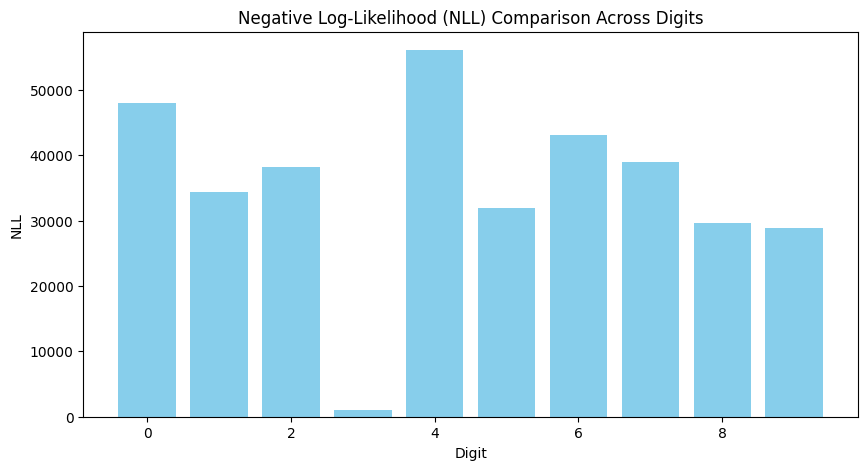

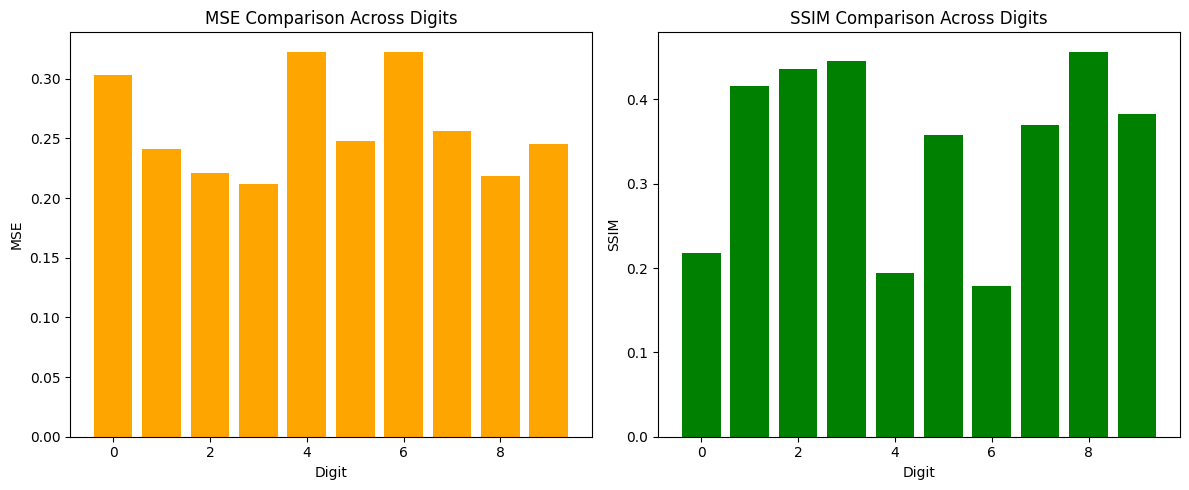

In [ ]:
# Visualize NLL comparison across digits
plt.figure(figsize=(10, 5))
plt.bar(digit_nlls.keys(), digit_nlls.values(), color="skyblue")
plt.xlabel("Digit")
plt.ylabel("NLL")
plt.title("Negative Log-Likelihood (NLL) Comparison Across Digits")
plt.show()

# Visualize MSE and SSIM
mse_vals = [digit_similarities[digit][0] for digit in range(10)]
ssim_vals = [digit_similarities[digit][1] for digit in range(10)]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(range(10), mse_vals, color="orange")
axs[0].set_title("MSE Comparison Across Digits")
axs[0].set_xlabel("Digit")
axs[0].set_ylabel("MSE")

axs[1].bar(range(10), ssim_vals, color="green")
axs[1].set_title("SSIM Comparison Across Digits")
axs[1].set_xlabel("Digit")
axs[1].set_ylabel("SSIM")

plt.tight_layout()
plt.show()


In [ ]:
# Compare Digit "0" against other digits
comparison_results = {}

for digit in range(1, 10):  # Skip digit 0
    # Generate samples from models for digit "0" and digit `digit`
    zero_samples = generate_samples(made_model, num_samples=50)
    digit_samples = generate_samples(made_model, num_samples=50, image_shape=(8, 8))

    # Compute similarity between "0" samples and `digit` samples
    mse, ssim_val = calculate_similarity(
        [zero.squeeze() for zero in zero_samples],
        [dgt.squeeze() for dgt in digit_samples]
    )

    # Store results
    comparison_results[digit] = (mse, ssim_val)
    print(f"Comparison 0 vs {digit} -> MSE: {mse:.4f}, SSIM: {ssim_val:.4f}")


Comparison 0 vs 1 -> MSE: 0.1112, SSIM: 0.7000
Comparison 0 vs 2 -> MSE: 0.1122, SSIM: 0.7049
Comparison 0 vs 3 -> MSE: 0.0881, SSIM: 0.7696
Comparison 0 vs 4 -> MSE: 0.1131, SSIM: 0.7000
Comparison 0 vs 5 -> MSE: 0.1241, SSIM: 0.6725
Comparison 0 vs 6 -> MSE: 0.1269, SSIM: 0.6655
Comparison 0 vs 7 -> MSE: 0.1222, SSIM: 0.6816
Comparison 0 vs 8 -> MSE: 0.1178, SSIM: 0.6906
Comparison 0 vs 9 -> MSE: 0.1091, SSIM: 0.7152


In [ ]:
def calculate_similarity(imgs1, imgs2):
    mse_vals = []
    ssim_vals = []

    for img1, img2 in zip(imgs1, imgs2):
        # Compute MSE (Mean Squared Error)
        mse_vals.append(np.mean((img1 - img2) ** 2))

        # Compute SSIM (Structural Similarity Index)
        ssim_vals.append(ssim(img1, img2, data_range=img1.max() - img1.min(), multichannel=False))

    mse = np.mean(mse_vals)
    ssim_val = np.mean(ssim_vals)

    return mse, ssim_val

# Assuming you already have `X_full` and `y_full` loaded from `load_digits`
X_full, y_full = load_digits(n_class=10, return_X_y=True)

# Binarize the data (adjust threshold as needed)
Xb_full = Binarizer(threshold=7).fit_transform(X_full)

# Split the data by digits (0-9)
class_data = {digit: Xb_full[y_full == digit] for digit in range(10)}

# Create datasets for each digit
datasets = {digit: BinDigits(data) for digit, data in class_data.items()}

# Data loaders for each digit
data_loaders = {digit: torch.utils.data.DataLoader(ds, batch_size=32) for digit, ds in datasets.items()}

# Initialize a dictionary to store comparison results
comparison_results = {}

# Compare digit "0" against the other digits (1-9)
for digit in range(1, 10):  # Skip digit 0
    # Get samples from digit "0" and the current digit
    zero_samples = class_data[0]  # Samples of digit "0"
    digit_samples = class_data[digit]  # Samples of the current digit

    # To ensure the same number of samples from each class, let's limit the number of samples
    num_samples = min(len(zero_samples), len(digit_samples), 50)  # Taking at most 50 samples

    zero_samples = zero_samples[:num_samples]
    digit_samples = digit_samples[:num_samples]

    # Compute similarity between digit "0" and the current digit samples
    mse, ssim_val = calculate_similarity(
        [zero.squeeze() for zero in zero_samples],  # Convert to NumPy arrays
        [dgt.squeeze() for dgt in digit_samples]   # Convert to NumPy arrays
    )

    # Store the results in the dictionary
    comparison_results[digit] = (mse, ssim_val)
    print(f"Comparison 0 vs {digit} -> MSE: {mse:.4f}, SSIM: {ssim_val:.4f}")

Comparison 0 vs 1 -> MSE: 0.3106, SSIM: 0.2616
Comparison 0 vs 2 -> MSE: 0.2969, SSIM: 0.2690
Comparison 0 vs 3 -> MSE: 0.2791, SSIM: 0.3002
Comparison 0 vs 4 -> MSE: 0.2759, SSIM: 0.3411
Comparison 0 vs 5 -> MSE: 0.2722, SSIM: 0.3349
Comparison 0 vs 6 -> MSE: 0.2372, SSIM: 0.4253
Comparison 0 vs 7 -> MSE: 0.3047, SSIM: 0.2602
Comparison 0 vs 8 -> MSE: 0.2437, SSIM: 0.4119
Comparison 0 vs 9 -> MSE: 0.2428, SSIM: 0.3992


In [ ]:
def nll(sample1, sample2):
    # Adding epsilon to prevent log(0) error
    epsilon = 1e-15
    snll = 0.0

    # Iterate over each pixel in the sample pair
    for i in range(sample1.shape[0]):
        mu = torch.sigmoid(torch.tensor(sample1[i]).float())  # Treat sample1 as prediction
        # We use sample2 as the target
        snll += ((sample2[i] * torch.log(mu + epsilon)) + ((1 - sample2[i]) * torch.log(1 - mu + epsilon))).sum()

    return -snll

# Example usage of the `nll` function in the comparison loop
comparison_results_with_nll = {}

for digit in range(0, 10):  # Compare digit "0" against digits 1-9
    # Get samples from digit "0" and the current digit
    zero_samples = class_data[0]  # Samples of digit "0"
    digit_samples = class_data[digit]  # Samples of the current digit

    # To ensure the same number of samples from each class, let's limit the number of samples
    num_samples = min(len(zero_samples), len(digit_samples), 50)  # Taking at most 50 samples

    zero_samples = zero_samples[:num_samples]
    digit_samples = digit_samples[:num_samples]

    # Compute similarity between digit "0" and the current digit samples
    mse, ssim_val = calculate_similarity(
        [zero.squeeze() for zero in zero_samples],  # Convert to NumPy arrays
        [dgt.squeeze() for dgt in digit_samples]   # Convert to NumPy arrays
    )

    # Compute NLL between the two samples
    nll_values = []
    for z, d in zip(zero_samples, digit_samples):
        nll_val = nll(z.squeeze(), d.squeeze())  # Squeeze and pass as flattened samples
        nll_values.append(nll_val.item())  # Convert tensor to a scalar value

    avg_nll = np.mean(nll_values)  # Compute the average NLL for this comparison

    # Store the results in the dictionary
    comparison_results_with_nll[digit] = (mse, ssim_val, avg_nll)
    print(f"Comparison 0 vs {digit} -> MSE: {mse:.4f}, SSIM: {ssim_val:.4f}, Avg NLL: {avg_nll:.4f}")

Comparison 0 vs 0 -> MSE: 0.0000, SSIM: 1.0000, Avg NLL: 35.8140
Comparison 0 vs 1 -> MSE: 0.3106, SSIM: 0.2616, Avg NLL: 46.9140
Comparison 0 vs 2 -> MSE: 0.2969, SSIM: 0.2690, Avg NLL: 46.3540
Comparison 0 vs 3 -> MSE: 0.2791, SSIM: 0.3002, Avg NLL: 45.9740
Comparison 0 vs 4 -> MSE: 0.2759, SSIM: 0.3411, Avg NLL: 45.9940
Comparison 0 vs 5 -> MSE: 0.2722, SSIM: 0.3349, Avg NLL: 45.2540
Comparison 0 vs 6 -> MSE: 0.2372, SSIM: 0.4253, Avg NLL: 43.9940
Comparison 0 vs 7 -> MSE: 0.3047, SSIM: 0.2602, Avg NLL: 46.8140
Comparison 0 vs 8 -> MSE: 0.2437, SSIM: 0.4119, Avg NLL: 43.6740
Comparison 0 vs 9 -> MSE: 0.2428, SSIM: 0.3992, Avg NLL: 44.3740



Final Results Summary:
NLL per Digit: {0: tensor(48038.9805), 1: tensor(34389.6875), 2: tensor(38116.2070), 3: tensor(1102.5527), 4: tensor(56064.5352), 5: tensor(31906.0410), 6: tensor(43114.6055), 7: tensor(38907.7188), 8: tensor(29598.1953), 9: tensor(28838.2773)}
Comparison of Generated '0' with Other Digits:
Digit 1 -> MSE: 0.3106, SSIM: 0.2616
Digit 2 -> MSE: 0.2969, SSIM: 0.2690
Digit 3 -> MSE: 0.2791, SSIM: 0.3002
Digit 4 -> MSE: 0.2759, SSIM: 0.3411
Digit 5 -> MSE: 0.2722, SSIM: 0.3349
Digit 6 -> MSE: 0.2372, SSIM: 0.4253
Digit 7 -> MSE: 0.3047, SSIM: 0.2602
Digit 8 -> MSE: 0.2437, SSIM: 0.4119
Digit 9 -> MSE: 0.2428, SSIM: 0.3992


TypeError: Invalid shape (64,) for image data

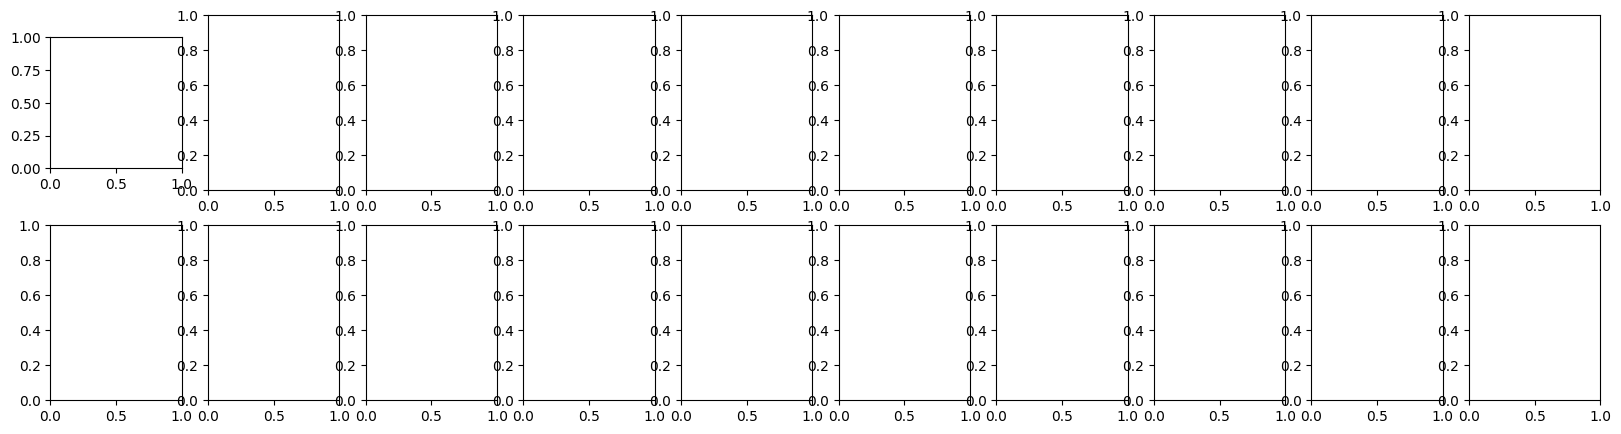

In [ ]:
# Final Summary of Results
print("\nFinal Results Summary:")
print(f"NLL per Digit: {digit_nlls}")
print("Comparison of Generated '0' with Other Digits:")
for digit in range(1, 10):
    mse, ssim_val = comparison_results[digit]
    print(f"Digit {digit} -> MSE: {mse:.4f}, SSIM: {ssim_val:.4f}")

# Visualizing examples of "0" vs other digits
fig, axs = plt.subplots(2, 10, figsize=(20, 5))
for i, zero_sample in enumerate(zero_samples[:5]):
    axs[0, i].imshow(zero_sample, cmap="gray")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"0 Sample {i+1}")

for i, digit_sample in enumerate(digit_samples[:5]):
    axs[1, i].imshow(digit_sample, cmap="gray")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Digit Sample {i+1}")

plt.tight_layout()
plt.show()


In [ ]:
def nll(model, samp):
    epsilon = 1e-15
    snll = 0.0
    for i in range(samp.shape[0]):
        mu = torch.sigmoid(model(samp[i]).detach())
        snll += ((samp[i] * torch.log(mu+epsilon)) + ((1-samp[i]) * torch.log(1-mu+epsilon))).sum()
    return -snll.cpu()

def nll2(model, samp):
    epsilon =1e-15
    snll = 0.0
    for i in range(samp.shape[0]):
        mu = torch.sigmoid(model(samp[i].unsqueeze(1)).detach())
        snll += ((samp[i] * torch.log(mu+epsilon)) + ((1-samp[i]) * torch.log(1-mu+epsilon))).sum()
    return -snll.cpu()

models = {"MADE model": made_model, "Pixel CNN": pcnn_model, "Image GPT": igpt_model, "Gated Pixel CNN": gpcnn_model} #"Pixel CNN double down": pcnn2_model, "Image GPT double down": igpt2_model

results = {name: [] for name in models}
for name, model in models.items():
  print (f"Model {name}")
  for i in range(10):
    Xo,y =  load_digits(n_class=10, return_X_y=True)
    X1 = Xo[y==i]
    Xb1 = Binarizer(threshold=7).fit_transform(X1)
    if name not in ["Pixel CNN double down", "Image GPT double down", "Gated Pixel CNN"]:
      result = nll(model, torch.tensor(Xb1[:100].reshape((-1,8,8)), dtype=torch.float32).unsqueeze(1).to(device))
    else:
      result = nll2(model, torch.tensor(Xb1[:100].reshape((-1,8,8)), dtype=torch.float32).unsqueeze(1).to(device))
    results[name].append(float(result))
    print(f"NLL for class {i}: {result}")

